In [2]:
from scipy.stats import poisson,norm
from math import log
#from scipy.integrate import simpson
from scipy.optimize import minimize
from functools import partial
from scipy.integrate import quad
import numpy as np
from matplotlib import pyplot as plt
#from scipy.integrate import cumulative_trapezoid
from scipy.stats import chi2
np.random.seed(3553)
from tqdm import tqdm

In [3]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('legend',fontsize=15)
plt.rc('font',size=15)

In [20]:
def model_poisson(n,s,b):
    return poisson(s+b).pmf(n)

def model_poisson_2d(n,x):
    s = x[0]
    b = x[1]
    return model_poisson(n,s,b)

def constraint_b(b,bmu,sigmab):
    return norm(loc=bmu,scale=sigmab).pdf(b) #visualizza la funzione di probabilità pdf. media bmu

def model_constraint_freq(n,s,b,bbar,sigmab):
    return model_poisson(n,s,b)*constraint_b(bbar,b,sigmab)

def generate_data(s, b, sigmab): # uguale a quella di merli nell'es 6, ma applicata a questo caso.
    # secondo me posso generarli un po come ercaz mi pare.
    n1 = np.random.randint(s+b-2*np.sqrt(s+b), s+b+2*np.sqrt(s+b), 10000) 
    bbar1 = np.random.uniform(b-2*sigmab, b+2*sigmab, 10000) 
    y = model_constraint_freq(n1, s, b, bbar1, sigmab)
    y1 = np.random.uniform(0, np.max(y), 10000) # devo aumenare a  10000 se no mi da errore che è troppo piccolo...
    return n1[y1 <= y][:ndata], bbar1[y1 <= y][:ndata] #accept-reject

def gen_dat(s, b, sigmab): #fanno schifo i risultati
    n1 = np.random.poisson(s+b,1000)
    bbar1 = np.random.normal(b,sigmab,1000)
    y = model_constraint_freq(n1, s, b, bbar1, sigmab)
    y1 = np.random.uniform(0, np.max(y), 1000)
    return n1[y1 <= y][:ndata], bbar1[y1 <= y][:ndata]

def generate_data_bibby(s, b, sigmab): #fanno schifo i risultati...non capisco il perchè.
    # secondo me posso generarli un po come cazzo mi pare.
    n1 = np.random.randint(s+b-2*np.sqrt(s+b), s+b+2*np.sqrt(s+b), 10000) #cambia i limiti a 
    #seconda di caso i o ii
    bbar1 = np.random.uniform(b-2*sigmab, b+2*sigmab, 10000) 
    y = model_constraint_freq(n1, s, b, bbar1, sigmab)
    y1 = np.random.uniform(0, np.max(y), 10000)
    return n1[y1 <= y][:ndata], bbar1[y1 <= y][:ndata] #accept-reject

def model_constraint_2d_freq(n,x,bbar,sigmab):
    s = x[0]
    b = x[1]
    return model_constraint_freq(n,s,b,bbar,sigmab)

def nll(model,n,s,b,**kwargs):
    return -np.log(model(n,s,b,**kwargs))

def nll_2d(model,n,x,**kwargs):
    return -np.log(model(n=n,x=x,**kwargs))

def testStatistic(model,n,s,b,bestNLL,**kwargs):
    return 2*(nll(model=model,n=n,s=s,b=b,**kwargs)-bestNLL)

In [7]:
ndata = 500
s = 50
b = 150
sigmab = 30
experiment = generate_data(s, b, sigmab)

limit = chi2(1).ppf(0.90) # 95% 
ok_upper_limit = 0

for i in tqdm( range (ndata) ):

    n = experiment[0][i]
    bbar = experiment[1][i]
    
    #res.x[0] è il segnale, res.x[1] il bkg
    res = minimize(partial(nll_2d,model_constraint_2d_freq,n,bbar=bbar,sigmab=sigmab),x0=(s,b),bounds=[(0,np.inf),(0,np.inf),]) # calcolo b capp e s capp
    bestNLL = res.fun
    t = np.array([])
    
    #par_s = np.linspace(res.x[0]-20, res.x[0]+40, 400) 
    par_s = np.linspace(20,200, 400) #deve essere intorno al 50...nel primo caso.
    
    print('sbest = %.2f'%(res.x[0]))
    for si in par_s:
        res = minimize(partial(nll,model_constraint_freq,n,si,bbar=bbar,sigmab=sigmab),x0=(b,),bounds=[(0,np.inf),])
        t = np.append(t,testStatistic(model=model_constraint_freq,n=n,s=si,b=res.x[0],bestNLL=bestNLL,bbar=bbar,sigmab=sigmab))
        
    #plt.plot(sig,t,label='Profiled likelihood ratio',lw=1)
    idx = (t>limit).argmax()
    if(idx != 0):
        upper_limit = 0.5*(par_s[idx]+par_s[idx-1])
    else:
        upper_limit = par_s[idx]
    print('sigmab = %.2f, n = %.2f, bbar = %.2f, limit = %.2f, upper limit on s = %.2f'%(sigmab, n, bbar, limit, upper_limit))

    file = open("mix.txt", "a")
    file.write(str(upper_limit) + "\n")
    file.close()

    if(upper_limit >= s):
        ok_upper_limit = ok_upper_limit + 1
        

  0%|          | 0/500 [00:00<?, ?it/s]

sbest = 60.47


  0%|          | 1/500 [00:13<1:51:50, 13.45s/it]

sigmab = 30.00, n = 192.00, bbar = 131.53, limit = 2.71, upper limit on s = 114.96
sbest = 50.59


  0%|          | 2/500 [00:27<1:53:27, 13.67s/it]

sigmab = 30.00, n = 219.00, bbar = 168.41, limit = 2.71, upper limit on s = 105.94
sbest = 51.63


  1%|          | 3/500 [00:41<1:56:15, 14.04s/it]

sigmab = 30.00, n = 211.00, bbar = 159.38, limit = 2.71, upper limit on s = 106.84
sbest = 44.43


  1%|          | 4/500 [00:56<1:58:34, 14.34s/it]

sigmab = 30.00, n = 216.00, bbar = 171.57, limit = 2.71, upper limit on s = 99.62
sbest = 31.08


  1%|          | 5/500 [01:08<1:52:00, 13.58s/it]

sigmab = 30.00, n = 182.00, bbar = 150.92, limit = 2.71, upper limit on s = 85.19
sbest = 47.12


  1%|          | 6/500 [01:22<1:50:55, 13.47s/it]

sigmab = 30.00, n = 201.00, bbar = 153.88, limit = 2.71, upper limit on s = 101.88
sbest = 25.07


  1%|▏         | 7/500 [01:34<1:49:03, 13.27s/it]

sigmab = 30.00, n = 174.00, bbar = 148.93, limit = 2.71, upper limit on s = 79.32
sbest = 55.58


  2%|▏         | 8/500 [01:48<1:48:52, 13.28s/it]

sigmab = 30.00, n = 218.00, bbar = 162.42, limit = 2.71, upper limit on s = 110.90
sbest = 71.65


  2%|▏         | 9/500 [02:01<1:48:23, 13.25s/it]

sigmab = 30.00, n = 197.00, bbar = 125.35, limit = 2.71, upper limit on s = 126.24
sbest = 105.34


  2%|▏         | 10/500 [02:15<1:49:46, 13.44s/it]

sigmab = 30.00, n = 206.00, bbar = 100.66, limit = 2.71, upper limit on s = 20.00
sbest = 0.00


  2%|▏         | 11/500 [02:27<1:46:03, 13.01s/it]

sigmab = 30.00, n = 192.00, bbar = 205.59, limit = 2.71, upper limit on s = 42.78
sbest = 0.36


  2%|▏         | 12/500 [02:41<1:49:41, 13.49s/it]

sigmab = 30.00, n = 198.00, bbar = 197.64, limit = 2.71, upper limit on s = 54.96
sbest = 34.09


  3%|▎         | 13/500 [02:54<1:47:08, 13.20s/it]

sigmab = 30.00, n = 191.00, bbar = 156.91, limit = 2.71, upper limit on s = 88.80
sbest = 49.32


  3%|▎         | 14/500 [03:07<1:46:50, 13.19s/it]

sigmab = 30.00, n = 216.00, bbar = 166.67, limit = 2.71, upper limit on s = 104.59
sbest = 16.87


  3%|▎         | 15/500 [03:20<1:45:58, 13.11s/it]

sigmab = 30.00, n = 192.00, bbar = 175.13, limit = 2.71, upper limit on s = 71.20
sbest = 3.81


  3%|▎         | 16/500 [03:33<1:44:52, 13.00s/it]

sigmab = 30.00, n = 205.00, bbar = 201.20, limit = 2.71, upper limit on s = 58.57
sbest = 72.83


  3%|▎         | 17/500 [03:46<1:45:17, 13.08s/it]

sigmab = 30.00, n = 206.00, bbar = 133.17, limit = 2.71, upper limit on s = 127.59
sbest = 58.78


  4%|▎         | 18/500 [04:00<1:46:40, 13.28s/it]

sigmab = 30.00, n = 196.00, bbar = 137.22, limit = 2.71, upper limit on s = 113.61
sbest = 42.41


  4%|▍         | 19/500 [04:12<1:44:20, 13.02s/it]

sigmab = 30.00, n = 199.00, bbar = 156.59, limit = 2.71, upper limit on s = 96.92
sbest = 34.99


  4%|▍         | 20/500 [04:24<1:41:29, 12.69s/it]

sigmab = 30.00, n = 185.00, bbar = 150.01, limit = 2.71, upper limit on s = 89.25
sbest = 79.27


  4%|▍         | 21/500 [04:37<1:41:40, 12.74s/it]

sigmab = 30.00, n = 220.00, bbar = 140.73, limit = 2.71, upper limit on s = 20.00
sbest = 39.70


  4%|▍         | 22/500 [04:49<1:40:57, 12.67s/it]

sigmab = 30.00, n = 197.00, bbar = 157.30, limit = 2.71, upper limit on s = 94.21
sbest = 66.67


  5%|▍         | 23/500 [05:03<1:43:17, 12.99s/it]

sigmab = 30.00, n = 194.00, bbar = 127.33, limit = 2.71, upper limit on s = 121.28
sbest = 10.35


  5%|▍         | 24/500 [05:16<1:42:56, 12.98s/it]

sigmab = 30.00, n = 208.00, bbar = 197.65, limit = 2.71, upper limit on s = 65.34
sbest = 59.78


  5%|▌         | 25/500 [05:30<1:44:58, 13.26s/it]

sigmab = 30.00, n = 199.00, bbar = 139.22, limit = 2.71, upper limit on s = 114.51
sbest = 41.43


  5%|▌         | 26/500 [05:43<1:45:11, 13.31s/it]

sigmab = 30.00, n = 208.00, bbar = 166.57, limit = 2.71, upper limit on s = 96.47
sbest = 36.01


  5%|▌         | 27/500 [05:56<1:42:32, 13.01s/it]

sigmab = 30.00, n = 186.00, bbar = 149.98, limit = 2.71, upper limit on s = 90.60
sbest = 58.69


  6%|▌         | 28/500 [06:09<1:41:43, 12.93s/it]

sigmab = 30.00, n = 196.00, bbar = 137.31, limit = 2.71, upper limit on s = 113.16
sbest = 28.08


  6%|▌         | 29/500 [06:22<1:43:36, 13.20s/it]

sigmab = 30.00, n = 209.00, bbar = 180.92, limit = 2.71, upper limit on s = 82.93
sbest = 24.62


  6%|▌         | 30/500 [06:35<1:42:33, 13.09s/it]

sigmab = 30.00, n = 194.00, bbar = 169.38, limit = 2.71, upper limit on s = 79.32
sbest = 42.44


  6%|▌         | 31/500 [06:50<1:46:13, 13.59s/it]

sigmab = 30.00, n = 193.00, bbar = 150.56, limit = 2.71, upper limit on s = 96.92
sbest = 64.49


  6%|▋         | 32/500 [07:04<1:47:33, 13.79s/it]

sigmab = 30.00, n = 209.00, bbar = 144.53, limit = 2.71, upper limit on s = 119.47
sbest = 30.07


  7%|▋         | 33/500 [07:20<1:52:21, 14.44s/it]

sigmab = 30.00, n = 194.00, bbar = 163.92, limit = 2.71, upper limit on s = 84.74
sbest = 132.64


  7%|▋         | 34/500 [07:35<1:52:35, 14.50s/it]

sigmab = 30.00, n = 225.00, bbar = 92.35, limit = 2.71, upper limit on s = 20.00
sbest = 52.98


  7%|▋         | 35/500 [07:48<1:50:19, 14.24s/it]

sigmab = 30.00, n = 191.00, bbar = 138.02, limit = 2.71, upper limit on s = 107.29
sbest = 54.03


  7%|▋         | 36/500 [08:01<1:45:30, 13.64s/it]

sigmab = 30.00, n = 189.00, bbar = 134.97, limit = 2.71, upper limit on s = 108.65
sbest = 30.22


  7%|▋         | 37/500 [08:14<1:44:32, 13.55s/it]

sigmab = 30.00, n = 216.00, bbar = 185.78, limit = 2.71, upper limit on s = 85.19
sbest = 41.58


  8%|▊         | 38/500 [08:28<1:44:38, 13.59s/it]

sigmab = 30.00, n = 217.00, bbar = 175.42, limit = 2.71, upper limit on s = 96.92
sbest = 50.29


  8%|▊         | 39/500 [08:41<1:43:51, 13.52s/it]

sigmab = 30.00, n = 178.00, bbar = 127.71, limit = 2.71, upper limit on s = 104.59
sbest = 41.60


  8%|▊         | 40/500 [08:55<1:44:15, 13.60s/it]

sigmab = 30.00, n = 202.00, bbar = 160.40, limit = 2.71, upper limit on s = 96.47
sbest = 0.00


  8%|▊         | 41/500 [09:08<1:41:58, 13.33s/it]

sigmab = 30.00, n = 179.00, bbar = 188.08, limit = 2.71, upper limit on s = 45.94
sbest = 25.09


  8%|▊         | 42/500 [09:21<1:41:45, 13.33s/it]

sigmab = 30.00, n = 201.00, bbar = 175.91, limit = 2.71, upper limit on s = 79.77
sbest = 91.73


  9%|▊         | 43/500 [09:35<1:44:14, 13.69s/it]

sigmab = 30.00, n = 206.00, bbar = 114.27, limit = 2.71, upper limit on s = 20.00
sbest = 60.08


  9%|▉         | 44/500 [09:49<1:43:09, 13.57s/it]

sigmab = 30.00, n = 184.00, bbar = 123.92, limit = 2.71, upper limit on s = 114.51
sbest = 20.10


  9%|▉         | 45/500 [10:01<1:40:04, 13.20s/it]

sigmab = 30.00, n = 190.00, bbar = 169.90, limit = 2.71, upper limit on s = 74.36
sbest = 68.61


  9%|▉         | 46/500 [10:14<1:39:06, 13.10s/it]

sigmab = 30.00, n = 223.00, bbar = 154.40, limit = 2.71, upper limit on s = 123.98
sbest = 1.14


  9%|▉         | 47/500 [10:27<1:38:36, 13.06s/it]

sigmab = 30.00, n = 207.00, bbar = 205.86, limit = 2.71, upper limit on s = 55.86
sbest = 17.95


 10%|▉         | 48/500 [10:39<1:36:30, 12.81s/it]

sigmab = 30.00, n = 189.00, bbar = 171.05, limit = 2.71, upper limit on s = 72.56
sbest = 77.36


 10%|▉         | 49/500 [10:54<1:39:57, 13.30s/it]

sigmab = 30.00, n = 196.00, bbar = 118.64, limit = 2.71, upper limit on s = 20.00
sbest = 43.74


 10%|█         | 50/500 [11:07<1:39:52, 13.32s/it]

sigmab = 30.00, n = 206.00, bbar = 162.26, limit = 2.71, upper limit on s = 98.72
sbest = 13.50


 10%|█         | 51/500 [11:19<1:37:23, 13.01s/it]

sigmab = 30.00, n = 187.00, bbar = 173.50, limit = 2.71, upper limit on s = 68.05
sbest = 34.64


 10%|█         | 52/500 [11:33<1:37:59, 13.12s/it]

sigmab = 30.00, n = 204.00, bbar = 169.36, limit = 2.71, upper limit on s = 89.25
sbest = 101.26


 11%|█         | 53/500 [11:46<1:39:30, 13.36s/it]

sigmab = 30.00, n = 225.00, bbar = 123.75, limit = 2.71, upper limit on s = 20.00
sbest = 27.55


 11%|█         | 54/500 [11:59<1:37:54, 13.17s/it]

sigmab = 30.00, n = 193.00, bbar = 165.45, limit = 2.71, upper limit on s = 82.03
sbest = 66.23


 11%|█         | 55/500 [12:13<1:39:10, 13.37s/it]

sigmab = 30.00, n = 209.00, bbar = 142.77, limit = 2.71, upper limit on s = 121.28
sbest = 60.36


 11%|█         | 56/500 [12:27<1:40:47, 13.62s/it]

sigmab = 30.00, n = 217.00, bbar = 156.64, limit = 2.71, upper limit on s = 115.41
sbest = 76.12


 11%|█▏        | 57/500 [12:42<1:43:37, 14.03s/it]

sigmab = 30.00, n = 210.00, bbar = 133.88, limit = 2.71, upper limit on s = 20.00
sbest = 59.82


 12%|█▏        | 58/500 [12:58<1:46:44, 14.49s/it]

sigmab = 30.00, n = 221.00, bbar = 161.17, limit = 2.71, upper limit on s = 114.96
sbest = 115.35


 12%|█▏        | 59/500 [13:13<1:48:11, 14.72s/it]

sigmab = 30.00, n = 227.00, bbar = 111.65, limit = 2.71, upper limit on s = 20.00
sbest = 27.90


 12%|█▏        | 60/500 [13:27<1:47:13, 14.62s/it]

sigmab = 30.00, n = 185.00, bbar = 157.11, limit = 2.71, upper limit on s = 82.03
sbest = 50.91


 12%|█▏        | 61/500 [13:43<1:49:04, 14.91s/it]

sigmab = 30.00, n = 186.00, bbar = 135.09, limit = 2.71, upper limit on s = 105.49
sbest = 80.92


 12%|█▏        | 62/500 [13:59<1:50:54, 15.19s/it]

sigmab = 30.00, n = 224.00, bbar = 143.08, limit = 2.71, upper limit on s = 20.00
sbest = 55.39


 13%|█▎        | 63/500 [14:14<1:50:40, 15.19s/it]

sigmab = 30.00, n = 180.00, bbar = 124.61, limit = 2.71, upper limit on s = 109.55
sbest = 48.74


 13%|█▎        | 64/500 [14:30<1:51:25, 15.33s/it]

sigmab = 30.00, n = 215.00, bbar = 166.26, limit = 2.71, upper limit on s = 103.68
sbest = 43.73


 13%|█▎        | 65/500 [14:44<1:48:51, 15.01s/it]

sigmab = 30.00, n = 209.00, bbar = 165.27, limit = 2.71, upper limit on s = 98.72
sbest = 13.01


 13%|█▎        | 66/500 [14:57<1:44:34, 14.46s/it]

sigmab = 30.00, n = 214.00, bbar = 200.99, limit = 2.71, upper limit on s = 68.05
sbest = 40.98


 13%|█▎        | 67/500 [15:10<1:41:05, 14.01s/it]

sigmab = 30.00, n = 192.00, bbar = 151.02, limit = 2.71, upper limit on s = 95.56
sbest = 32.57


 14%|█▎        | 68/500 [15:24<1:41:16, 14.07s/it]

sigmab = 30.00, n = 194.00, bbar = 161.43, limit = 2.71, upper limit on s = 86.99
sbest = 72.67


 14%|█▍        | 69/500 [15:38<1:39:38, 13.87s/it]

sigmab = 30.00, n = 209.00, bbar = 136.32, limit = 2.71, upper limit on s = 127.59
sbest = 83.19


 14%|█▍        | 70/500 [15:52<1:40:56, 14.09s/it]

sigmab = 30.00, n = 224.00, bbar = 140.81, limit = 2.71, upper limit on s = 20.00
sbest = 41.93


 14%|█▍        | 71/500 [16:06<1:40:00, 13.99s/it]

sigmab = 30.00, n = 194.00, bbar = 152.07, limit = 2.71, upper limit on s = 96.47
sbest = 83.45


 14%|█▍        | 72/500 [16:19<1:37:52, 13.72s/it]

sigmab = 30.00, n = 210.00, bbar = 126.56, limit = 2.71, upper limit on s = 20.00
sbest = 85.98


 15%|█▍        | 73/500 [16:34<1:40:18, 14.10s/it]

sigmab = 30.00, n = 214.00, bbar = 128.02, limit = 2.71, upper limit on s = 20.00
sbest = 64.57


 15%|█▍        | 74/500 [16:48<1:39:30, 14.02s/it]

sigmab = 30.00, n = 200.00, bbar = 135.44, limit = 2.71, upper limit on s = 119.47
sbest = 11.75


 15%|█▌        | 75/500 [17:01<1:37:05, 13.71s/it]

sigmab = 30.00, n = 188.00, bbar = 176.25, limit = 2.71, upper limit on s = 66.24
sbest = 27.83


 15%|█▌        | 76/500 [17:15<1:37:39, 13.82s/it]

sigmab = 30.00, n = 220.00, bbar = 192.17, limit = 2.71, upper limit on s = 82.93
sbest = 42.63


 15%|█▌        | 77/500 [17:28<1:36:37, 13.71s/it]

sigmab = 30.00, n = 214.00, bbar = 171.37, limit = 2.71, upper limit on s = 97.82
sbest = 16.81


 16%|█▌        | 78/500 [17:42<1:36:11, 13.68s/it]

sigmab = 30.00, n = 174.00, bbar = 157.19, limit = 2.71, upper limit on s = 70.75
sbest = 48.46


 16%|█▌        | 79/500 [17:56<1:36:17, 13.72s/it]

sigmab = 30.00, n = 201.00, bbar = 152.54, limit = 2.71, upper limit on s = 103.23
sbest = 26.38


 16%|█▌        | 80/500 [18:09<1:33:44, 13.39s/it]

sigmab = 30.00, n = 183.00, bbar = 156.62, limit = 2.71, upper limit on s = 80.68
sbest = 89.13


 16%|█▌        | 81/500 [18:23<1:35:17, 13.65s/it]

sigmab = 30.00, n = 211.00, bbar = 121.87, limit = 2.71, upper limit on s = 20.00
sbest = 95.58


 16%|█▋        | 82/500 [18:38<1:38:59, 14.21s/it]

sigmab = 30.00, n = 202.00, bbar = 106.42, limit = 2.71, upper limit on s = 20.00
sbest = 33.86


 17%|█▋        | 83/500 [18:53<1:40:02, 14.39s/it]

sigmab = 30.00, n = 182.00, bbar = 148.14, limit = 2.71, upper limit on s = 88.35
sbest = 57.60


 17%|█▋        | 84/500 [19:07<1:39:20, 14.33s/it]

sigmab = 30.00, n = 186.00, bbar = 128.40, limit = 2.71, upper limit on s = 111.80
sbest = 73.06


 17%|█▋        | 85/500 [19:23<1:42:39, 14.84s/it]

sigmab = 30.00, n = 220.00, bbar = 146.93, limit = 2.71, upper limit on s = 128.50
sbest = 49.68


 17%|█▋        | 86/500 [19:38<1:41:17, 14.68s/it]

sigmab = 30.00, n = 182.00, bbar = 132.32, limit = 2.71, upper limit on s = 104.14
sbest = 56.20


 17%|█▋        | 87/500 [19:54<1:44:16, 15.15s/it]

sigmab = 30.00, n = 215.00, bbar = 158.80, limit = 2.71, upper limit on s = 111.35
sbest = 0.14


 18%|█▊        | 88/500 [20:07<1:38:55, 14.41s/it]

sigmab = 30.00, n = 185.00, bbar = 184.86, limit = 2.71, upper limit on s = 54.51
sbest = 48.36


 18%|█▊        | 89/500 [20:21<1:37:47, 14.28s/it]

sigmab = 30.00, n = 212.00, bbar = 163.64, limit = 2.71, upper limit on s = 103.23
sbest = 29.63


 18%|█▊        | 90/500 [20:34<1:36:01, 14.05s/it]

sigmab = 30.00, n = 173.00, bbar = 143.37, limit = 2.71, upper limit on s = 83.83
sbest = 53.43


 18%|█▊        | 91/500 [20:48<1:35:01, 13.94s/it]

sigmab = 30.00, n = 186.00, bbar = 132.57, limit = 2.71, upper limit on s = 107.74
sbest = 108.62


 18%|█▊        | 92/500 [21:02<1:35:37, 14.06s/it]

sigmab = 30.00, n = 209.00, bbar = 100.38, limit = 2.71, upper limit on s = 20.00
sbest = 28.58


 19%|█▊        | 93/500 [21:16<1:35:42, 14.11s/it]

sigmab = 30.00, n = 201.00, bbar = 172.42, limit = 2.71, upper limit on s = 83.38
sbest = 88.19


 19%|█▉        | 94/500 [21:30<1:35:34, 14.13s/it]

sigmab = 30.00, n = 204.00, bbar = 115.81, limit = 2.71, upper limit on s = 20.00
sbest = 91.50


 19%|█▉        | 95/500 [21:44<1:34:16, 13.97s/it]

sigmab = 30.00, n = 215.00, bbar = 123.50, limit = 2.71, upper limit on s = 20.00
sbest = 73.32


 19%|█▉        | 96/500 [21:58<1:33:49, 13.93s/it]

sigmab = 30.00, n = 205.00, bbar = 131.68, limit = 2.71, upper limit on s = 128.05
sbest = 56.09


 19%|█▉        | 97/500 [22:11<1:31:45, 13.66s/it]

sigmab = 30.00, n = 218.00, bbar = 161.91, limit = 2.71, upper limit on s = 111.35
sbest = 34.99


 20%|█▉        | 98/500 [22:25<1:31:55, 13.72s/it]

sigmab = 30.00, n = 203.00, bbar = 168.00, limit = 2.71, upper limit on s = 89.70
sbest = 84.33


 20%|█▉        | 99/500 [22:40<1:34:56, 14.20s/it]

sigmab = 30.00, n = 218.00, bbar = 133.68, limit = 2.71, upper limit on s = 20.00
sbest = 39.43


 20%|██        | 100/500 [22:54<1:34:59, 14.25s/it]

sigmab = 30.00, n = 192.00, bbar = 152.57, limit = 2.71, upper limit on s = 93.76
sbest = 80.05


 20%|██        | 101/500 [23:09<1:35:04, 14.30s/it]

sigmab = 30.00, n = 204.00, bbar = 123.95, limit = 2.71, upper limit on s = 20.00
sbest = 0.00


 20%|██        | 102/500 [23:23<1:33:56, 14.16s/it]

sigmab = 30.00, n = 198.00, bbar = 198.71, limit = 2.71, upper limit on s = 54.06
sbest = 50.93


 21%|██        | 103/500 [23:36<1:31:41, 13.86s/it]

sigmab = 30.00, n = 198.00, bbar = 147.07, limit = 2.71, upper limit on s = 105.49
sbest = 85.67


 21%|██        | 104/500 [23:50<1:31:27, 13.86s/it]

sigmab = 30.00, n = 214.00, bbar = 128.34, limit = 2.71, upper limit on s = 20.00
sbest = 0.20


 21%|██        | 105/500 [24:03<1:30:19, 13.72s/it]

sigmab = 30.00, n = 193.00, bbar = 192.80, limit = 2.71, upper limit on s = 54.96
sbest = 20.36


 21%|██        | 106/500 [24:18<1:33:16, 14.20s/it]

sigmab = 30.00, n = 195.00, bbar = 174.64, limit = 2.71, upper limit on s = 74.81
sbest = 92.88


 21%|██▏       | 107/500 [24:33<1:34:24, 14.41s/it]

sigmab = 30.00, n = 210.00, bbar = 117.13, limit = 2.71, upper limit on s = 20.00
sbest = 39.67


 22%|██▏       | 108/500 [24:47<1:32:17, 14.13s/it]

sigmab = 30.00, n = 201.00, bbar = 161.33, limit = 2.71, upper limit on s = 94.21
sbest = 0.00


 22%|██▏       | 109/500 [24:59<1:27:39, 13.45s/it]

sigmab = 30.00, n = 183.00, bbar = 207.72, limit = 2.71, upper limit on s = 35.11
sbest = 10.88


 22%|██▏       | 110/500 [25:10<1:24:05, 12.94s/it]

sigmab = 30.00, n = 186.00, bbar = 175.12, limit = 2.71, upper limit on s = 65.34
sbest = 96.77


 22%|██▏       | 111/500 [25:25<1:26:19, 13.31s/it]

sigmab = 30.00, n = 201.00, bbar = 104.24, limit = 2.71, upper limit on s = 20.00
sbest = 82.09


 22%|██▏       | 112/500 [25:38<1:25:27, 13.22s/it]

sigmab = 30.00, n = 222.00, bbar = 139.92, limit = 2.71, upper limit on s = 20.00
sbest = 94.77


 23%|██▎       | 113/500 [25:51<1:25:18, 13.23s/it]

sigmab = 30.00, n = 192.00, bbar = 97.23, limit = 2.71, upper limit on s = 20.00
sbest = 115.04


 23%|██▎       | 114/500 [26:04<1:25:44, 13.33s/it]

sigmab = 30.00, n = 208.00, bbar = 92.96, limit = 2.71, upper limit on s = 20.00
sbest = 47.93


 23%|██▎       | 115/500 [26:18<1:26:02, 13.41s/it]

sigmab = 30.00, n = 210.00, bbar = 162.07, limit = 2.71, upper limit on s = 102.78
sbest = 26.71


 23%|██▎       | 116/500 [26:30<1:23:33, 13.06s/it]

sigmab = 30.00, n = 188.00, bbar = 161.28, limit = 2.71, upper limit on s = 81.13
sbest = 56.09


 23%|██▎       | 117/500 [26:43<1:22:19, 12.90s/it]

sigmab = 30.00, n = 210.00, bbar = 153.91, limit = 2.71, upper limit on s = 110.90
sbest = 35.88


 24%|██▎       | 118/500 [26:56<1:22:23, 12.94s/it]

sigmab = 30.00, n = 179.00, bbar = 143.13, limit = 2.71, upper limit on s = 90.15
sbest = 63.76


 24%|██▍       | 119/500 [27:09<1:22:33, 13.00s/it]

sigmab = 30.00, n = 220.00, bbar = 156.24, limit = 2.71, upper limit on s = 119.02
sbest = 27.38


 24%|██▍       | 120/500 [27:24<1:26:59, 13.74s/it]

sigmab = 30.00, n = 190.00, bbar = 162.61, limit = 2.71, upper limit on s = 82.03
sbest = 43.86


 24%|██▍       | 121/500 [27:41<1:31:35, 14.50s/it]

sigmab = 30.00, n = 220.00, bbar = 176.14, limit = 2.71, upper limit on s = 99.17
sbest = 48.61


 24%|██▍       | 122/500 [27:56<1:32:12, 14.64s/it]

sigmab = 30.00, n = 175.00, bbar = 126.38, limit = 2.71, upper limit on s = 102.78
sbest = 52.30


 25%|██▍       | 123/500 [28:12<1:35:39, 15.23s/it]

sigmab = 30.00, n = 205.00, bbar = 152.70, limit = 2.71, upper limit on s = 107.29
sbest = 0.44


 25%|██▍       | 124/500 [28:27<1:33:51, 14.98s/it]

sigmab = 30.00, n = 188.00, bbar = 187.56, limit = 2.71, upper limit on s = 54.96
sbest = 57.46


 25%|██▌       | 125/500 [28:43<1:35:14, 15.24s/it]

sigmab = 30.00, n = 205.00, bbar = 147.54, limit = 2.71, upper limit on s = 112.26
sbest = 70.85


 25%|██▌       | 126/500 [28:59<1:36:21, 15.46s/it]

sigmab = 30.00, n = 209.00, bbar = 138.16, limit = 2.71, upper limit on s = 125.79
sbest = 75.78


 25%|██▌       | 127/500 [29:14<1:36:11, 15.47s/it]

sigmab = 30.00, n = 214.00, bbar = 138.22, limit = 2.71, upper limit on s = 20.00
sbest = 63.32


 26%|██▌       | 128/500 [29:29<1:35:46, 15.45s/it]

sigmab = 30.00, n = 175.00, bbar = 111.68, limit = 2.71, upper limit on s = 117.22
sbest = 6.40


 26%|██▌       | 129/500 [29:44<1:34:32, 15.29s/it]

sigmab = 30.00, n = 185.00, bbar = 178.60, limit = 2.71, upper limit on s = 60.83
sbest = 52.70


 26%|██▌       | 130/500 [29:58<1:30:56, 14.75s/it]

sigmab = 30.00, n = 207.00, bbar = 154.30, limit = 2.71, upper limit on s = 107.74
sbest = 51.23


 26%|██▌       | 131/500 [30:10<1:25:50, 13.96s/it]

sigmab = 30.00, n = 184.00, bbar = 132.77, limit = 2.71, upper limit on s = 105.49
sbest = 0.00


 26%|██▋       | 132/500 [30:22<1:22:45, 13.49s/it]

sigmab = 30.00, n = 194.00, bbar = 195.53, limit = 2.71, upper limit on s = 53.16
sbest = 78.94


 27%|██▋       | 133/500 [30:37<1:23:57, 13.73s/it]

sigmab = 30.00, n = 200.00, bbar = 121.05, limit = 2.71, upper limit on s = 20.00
sbest = 84.17


 27%|██▋       | 134/500 [30:51<1:24:11, 13.80s/it]

sigmab = 30.00, n = 209.00, bbar = 124.83, limit = 2.71, upper limit on s = 20.00
sbest = 91.91


 27%|██▋       | 135/500 [31:05<1:25:11, 14.00s/it]

sigmab = 30.00, n = 199.00, bbar = 107.09, limit = 2.71, upper limit on s = 20.00
sbest = 1.31


 27%|██▋       | 136/500 [31:19<1:25:12, 14.05s/it]

sigmab = 30.00, n = 181.00, bbar = 179.70, limit = 2.71, upper limit on s = 55.41
sbest = 26.79


 27%|██▋       | 137/500 [31:32<1:23:12, 13.75s/it]

sigmab = 30.00, n = 187.00, bbar = 160.21, limit = 2.71, upper limit on s = 81.13
sbest = 48.84


 28%|██▊       | 138/500 [31:47<1:24:16, 13.97s/it]

sigmab = 30.00, n = 192.00, bbar = 143.16, limit = 2.71, upper limit on s = 103.23
sbest = 59.81


 28%|██▊       | 139/500 [32:03<1:28:37, 14.73s/it]

sigmab = 30.00, n = 196.00, bbar = 136.20, limit = 2.71, upper limit on s = 114.51
sbest = 65.47


 28%|██▊       | 140/500 [32:19<1:30:41, 15.12s/it]

sigmab = 30.00, n = 211.00, bbar = 145.53, limit = 2.71, upper limit on s = 120.38
sbest = 85.07


 28%|██▊       | 141/500 [32:34<1:30:32, 15.13s/it]

sigmab = 30.00, n = 179.00, bbar = 93.93, limit = 2.71, upper limit on s = 20.00
sbest = 36.25


 28%|██▊       | 142/500 [32:50<1:31:29, 15.33s/it]

sigmab = 30.00, n = 206.00, bbar = 169.75, limit = 2.71, upper limit on s = 91.05
sbest = 10.23


 29%|██▊       | 143/500 [33:05<1:29:48, 15.09s/it]

sigmab = 30.00, n = 195.00, bbar = 184.77, limit = 2.71, upper limit on s = 64.89
sbest = 41.59


 29%|██▉       | 144/500 [33:21<1:31:20, 15.39s/it]

sigmab = 30.00, n = 210.00, bbar = 168.41, limit = 2.71, upper limit on s = 96.47
sbest = 64.07


 29%|██▉       | 145/500 [33:36<1:31:13, 15.42s/it]

sigmab = 30.00, n = 205.00, bbar = 140.94, limit = 2.71, upper limit on s = 119.02
sbest = 60.39


 29%|██▉       | 146/500 [33:53<1:33:38, 15.87s/it]

sigmab = 30.00, n = 202.00, bbar = 141.60, limit = 2.71, upper limit on s = 114.96
sbest = 8.82


 29%|██▉       | 147/500 [34:08<1:32:00, 15.64s/it]

sigmab = 30.00, n = 175.00, bbar = 166.19, limit = 2.71, upper limit on s = 63.08
sbest = 41.78


 30%|██▉       | 148/500 [34:25<1:33:25, 15.93s/it]

sigmab = 30.00, n = 215.00, bbar = 173.22, limit = 2.71, upper limit on s = 96.92
sbest = 39.79


 30%|██▉       | 149/500 [34:41<1:32:48, 15.86s/it]

sigmab = 30.00, n = 217.00, bbar = 177.21, limit = 2.71, upper limit on s = 95.11
sbest = 46.04


 30%|███       | 150/500 [34:56<1:31:29, 15.69s/it]

sigmab = 30.00, n = 200.00, bbar = 153.97, limit = 2.71, upper limit on s = 100.98
sbest = 54.33


 30%|███       | 151/500 [35:08<1:24:08, 14.47s/it]

sigmab = 30.00, n = 200.00, bbar = 145.68, limit = 2.71, upper limit on s = 109.10
sbest = 17.10


 30%|███       | 152/500 [35:19<1:18:31, 13.54s/it]

sigmab = 30.00, n = 198.00, bbar = 180.90, limit = 2.71, upper limit on s = 71.65
sbest = 56.14


 31%|███       | 153/500 [35:31<1:15:02, 12.97s/it]

sigmab = 30.00, n = 199.00, bbar = 142.86, limit = 2.71, upper limit on s = 110.90
sbest = 95.01


 31%|███       | 154/500 [35:47<1:20:43, 14.00s/it]

sigmab = 30.00, n = 205.00, bbar = 109.98, limit = 2.71, upper limit on s = 20.00
sbest = 78.93


 31%|███       | 155/500 [36:03<1:24:31, 14.70s/it]

sigmab = 30.00, n = 203.00, bbar = 124.07, limit = 2.71, upper limit on s = 20.00
sbest = 16.49


 31%|███       | 156/500 [36:18<1:24:36, 14.76s/it]

sigmab = 30.00, n = 192.00, bbar = 175.51, limit = 2.71, upper limit on s = 71.20
sbest = 107.32


 31%|███▏      | 157/500 [36:35<1:27:36, 15.32s/it]

sigmab = 30.00, n = 220.00, bbar = 112.68, limit = 2.71, upper limit on s = 20.00
sbest = 53.85


 32%|███▏      | 158/500 [36:51<1:28:13, 15.48s/it]

sigmab = 30.00, n = 215.00, bbar = 161.15, limit = 2.71, upper limit on s = 109.10
sbest = 14.65


 32%|███▏      | 159/500 [37:06<1:26:50, 15.28s/it]

sigmab = 30.00, n = 193.00, bbar = 178.34, limit = 2.71, upper limit on s = 69.40
sbest = 22.05


 32%|███▏      | 160/500 [37:22<1:28:09, 15.56s/it]

sigmab = 30.00, n = 201.00, bbar = 178.95, limit = 2.71, upper limit on s = 76.62
sbest = 50.90


 32%|███▏      | 161/500 [37:37<1:26:48, 15.37s/it]

sigmab = 30.00, n = 185.00, bbar = 134.10, limit = 2.71, upper limit on s = 105.04
sbest = 79.96


 32%|███▏      | 162/500 [37:53<1:27:46, 15.58s/it]

sigmab = 30.00, n = 190.00, bbar = 110.04, limit = 2.71, upper limit on s = 20.00
sbest = 65.18


 33%|███▎      | 163/500 [38:08<1:26:41, 15.44s/it]

sigmab = 30.00, n = 190.00, bbar = 124.82, limit = 2.71, upper limit on s = 119.47
sbest = 21.03


 33%|███▎      | 164/500 [38:23<1:26:33, 15.46s/it]

sigmab = 30.00, n = 195.00, bbar = 173.98, limit = 2.71, upper limit on s = 75.71
sbest = 75.02


 33%|███▎      | 165/500 [38:40<1:28:49, 15.91s/it]

sigmab = 30.00, n = 200.00, bbar = 124.98, limit = 2.71, upper limit on s = 20.00
sbest = 65.62


 33%|███▎      | 166/500 [38:56<1:27:43, 15.76s/it]

sigmab = 30.00, n = 215.00, bbar = 149.38, limit = 2.71, upper limit on s = 120.83
sbest = 26.08


 33%|███▎      | 167/500 [39:10<1:24:24, 15.21s/it]

sigmab = 30.00, n = 191.00, bbar = 164.92, limit = 2.71, upper limit on s = 80.68
sbest = 0.00


 34%|███▎      | 168/500 [39:24<1:23:06, 15.02s/it]

sigmab = 30.00, n = 175.00, bbar = 181.29, limit = 2.71, upper limit on s = 48.20
sbest = 91.19


 34%|███▍      | 169/500 [39:40<1:23:49, 15.19s/it]

sigmab = 30.00, n = 205.00, bbar = 113.81, limit = 2.71, upper limit on s = 20.00
sbest = 35.88


 34%|███▍      | 170/500 [39:54<1:22:35, 15.02s/it]

sigmab = 30.00, n = 190.00, bbar = 154.12, limit = 2.71, upper limit on s = 90.15
sbest = 10.59


 34%|███▍      | 171/500 [40:09<1:21:06, 14.79s/it]

sigmab = 30.00, n = 191.00, bbar = 180.41, limit = 2.71, upper limit on s = 64.89
sbest = 80.84


 34%|███▍      | 172/500 [40:24<1:22:19, 15.06s/it]

sigmab = 30.00, n = 215.00, bbar = 134.16, limit = 2.71, upper limit on s = 20.00
sbest = 43.36


 35%|███▍      | 173/500 [40:40<1:22:21, 15.11s/it]

sigmab = 30.00, n = 197.00, bbar = 153.64, limit = 2.71, upper limit on s = 97.82
sbest = 19.53


 35%|███▍      | 174/500 [40:54<1:20:43, 14.86s/it]

sigmab = 30.00, n = 180.00, bbar = 160.47, limit = 2.71, upper limit on s = 73.91
sbest = 36.12


 35%|███▌      | 175/500 [41:10<1:22:07, 15.16s/it]

sigmab = 30.00, n = 202.00, bbar = 165.89, limit = 2.71, upper limit on s = 91.05
sbest = 46.98


 35%|███▌      | 176/500 [41:26<1:23:52, 15.53s/it]

sigmab = 30.00, n = 199.00, bbar = 152.03, limit = 2.71, upper limit on s = 101.88
sbest = 25.59


 35%|███▌      | 177/500 [41:41<1:22:46, 15.38s/it]

sigmab = 30.00, n = 192.00, bbar = 166.40, limit = 2.71, upper limit on s = 80.23
sbest = 52.87


 36%|███▌      | 178/500 [41:58<1:25:08, 15.87s/it]

sigmab = 30.00, n = 196.00, bbar = 143.12, limit = 2.71, upper limit on s = 107.29
sbest = 8.84


 36%|███▌      | 179/500 [42:14<1:25:12, 15.93s/it]

sigmab = 30.00, n = 210.00, bbar = 201.17, limit = 2.71, upper limit on s = 63.98
sbest = 18.86


 36%|███▌      | 180/500 [42:31<1:25:42, 16.07s/it]

sigmab = 30.00, n = 208.00, bbar = 189.13, limit = 2.71, upper limit on s = 73.91
sbest = 33.76


 36%|███▌      | 181/500 [42:46<1:24:52, 15.96s/it]

sigmab = 30.00, n = 175.00, bbar = 141.24, limit = 2.71, upper limit on s = 87.89
sbest = 71.78


 36%|███▋      | 182/500 [43:02<1:24:02, 15.86s/it]

sigmab = 30.00, n = 211.00, bbar = 139.22, limit = 2.71, upper limit on s = 126.69
sbest = 49.71


 37%|███▋      | 183/500 [43:17<1:22:22, 15.59s/it]

sigmab = 30.00, n = 214.00, bbar = 164.29, limit = 2.71, upper limit on s = 104.59
sbest = 59.42


 37%|███▋      | 184/500 [43:32<1:21:59, 15.57s/it]

sigmab = 30.00, n = 203.00, bbar = 143.57, limit = 2.71, upper limit on s = 114.06
sbest = 46.58


 37%|███▋      | 185/500 [43:47<1:20:15, 15.29s/it]

sigmab = 30.00, n = 188.00, bbar = 141.42, limit = 2.71, upper limit on s = 100.98
sbest = 72.33


 37%|███▋      | 186/500 [44:02<1:19:31, 15.20s/it]

sigmab = 30.00, n = 210.00, bbar = 137.67, limit = 2.71, upper limit on s = 127.14
sbest = 0.00


 37%|███▋      | 187/500 [44:16<1:17:18, 14.82s/it]

sigmab = 30.00, n = 188.00, bbar = 189.00, limit = 2.71, upper limit on s = 53.61
sbest = 64.31


 38%|███▊      | 188/500 [44:31<1:16:46, 14.76s/it]

sigmab = 30.00, n = 189.00, bbar = 124.70, limit = 2.71, upper limit on s = 118.57
sbest = 54.65


 38%|███▊      | 189/500 [44:47<1:18:35, 15.16s/it]

sigmab = 30.00, n = 180.00, bbar = 125.35, limit = 2.71, upper limit on s = 108.65
sbest = 8.40


 38%|███▊      | 190/500 [45:01<1:17:22, 14.97s/it]

sigmab = 30.00, n = 180.00, bbar = 171.60, limit = 2.71, upper limit on s = 62.63
sbest = 71.11


 38%|███▊      | 191/500 [45:16<1:16:22, 14.83s/it]

sigmab = 30.00, n = 189.00, bbar = 117.89, limit = 2.71, upper limit on s = 125.34
sbest = 33.30


 38%|███▊      | 192/500 [45:31<1:16:10, 14.84s/it]

sigmab = 30.00, n = 176.00, bbar = 142.70, limit = 2.71, upper limit on s = 87.44
sbest = 6.10


 39%|███▊      | 193/500 [45:46<1:16:16, 14.91s/it]

sigmab = 30.00, n = 174.00, bbar = 167.90, limit = 2.71, upper limit on s = 60.38
sbest = 0.00


 39%|███▉      | 194/500 [46:02<1:18:07, 15.32s/it]

sigmab = 30.00, n = 200.00, bbar = 201.96, limit = 2.71, upper limit on s = 52.71
sbest = 44.01


 39%|███▉      | 195/500 [46:17<1:17:13, 15.19s/it]

sigmab = 30.00, n = 189.00, bbar = 144.99, limit = 2.71, upper limit on s = 98.27
sbest = 45.21


 39%|███▉      | 196/500 [46:32<1:16:26, 15.09s/it]

sigmab = 30.00, n = 199.00, bbar = 153.79, limit = 2.71, upper limit on s = 100.08
sbest = 53.95


 39%|███▉      | 197/500 [46:48<1:18:11, 15.48s/it]

sigmab = 30.00, n = 208.00, bbar = 154.05, limit = 2.71, upper limit on s = 109.10
sbest = 54.59


 40%|███▉      | 198/500 [47:04<1:19:11, 15.73s/it]

sigmab = 30.00, n = 203.00, bbar = 148.42, limit = 2.71, upper limit on s = 109.55
sbest = 29.41


 40%|███▉      | 199/500 [47:21<1:19:31, 15.85s/it]

sigmab = 30.00, n = 218.00, bbar = 188.59, limit = 2.71, upper limit on s = 84.74
sbest = 112.21


 40%|████      | 200/500 [47:37<1:20:21, 16.07s/it]

sigmab = 30.00, n = 213.00, bbar = 100.78, limit = 2.71, upper limit on s = 20.00
sbest = 67.60


 40%|████      | 201/500 [47:52<1:17:37, 15.58s/it]

sigmab = 30.00, n = 190.00, bbar = 122.40, limit = 2.71, upper limit on s = 122.18
sbest = 53.63


 40%|████      | 202/500 [48:08<1:18:02, 15.71s/it]

sigmab = 30.00, n = 199.00, bbar = 145.37, limit = 2.71, upper limit on s = 108.20
sbest = 39.17


 41%|████      | 203/500 [48:22<1:16:23, 15.43s/it]

sigmab = 30.00, n = 181.00, bbar = 141.83, limit = 2.71, upper limit on s = 93.31
sbest = 16.25


 41%|████      | 204/500 [48:36<1:14:01, 15.00s/it]

sigmab = 30.00, n = 185.00, bbar = 168.75, limit = 2.71, upper limit on s = 70.75
sbest = 35.63


 41%|████      | 205/500 [48:52<1:14:15, 15.10s/it]

sigmab = 30.00, n = 196.00, bbar = 160.36, limit = 2.71, upper limit on s = 90.15
sbest = 76.62


 41%|████      | 206/500 [49:10<1:19:06, 16.14s/it]

sigmab = 30.00, n = 201.00, bbar = 124.38, limit = 2.71, upper limit on s = 20.00
sbest = 35.17


 41%|████▏     | 207/500 [49:27<1:20:05, 16.40s/it]

sigmab = 30.00, n = 210.00, bbar = 174.83, limit = 2.71, upper limit on s = 90.15
sbest = 55.21


 42%|████▏     | 208/500 [49:42<1:16:53, 15.80s/it]

sigmab = 30.00, n = 190.00, bbar = 134.79, limit = 2.71, upper limit on s = 109.55
sbest = 101.97


 42%|████▏     | 209/500 [49:58<1:17:26, 15.97s/it]

sigmab = 30.00, n = 204.00, bbar = 102.03, limit = 2.71, upper limit on s = 20.00
sbest = 89.09


 42%|████▏     | 210/500 [50:13<1:16:20, 15.80s/it]

sigmab = 30.00, n = 219.00, bbar = 129.92, limit = 2.71, upper limit on s = 20.00
sbest = 33.89


 42%|████▏     | 211/500 [50:32<1:20:42, 16.76s/it]

sigmab = 30.00, n = 183.00, bbar = 149.11, limit = 2.71, upper limit on s = 88.35
sbest = 69.82


 42%|████▏     | 212/500 [50:56<1:29:33, 18.66s/it]

sigmab = 30.00, n = 188.00, bbar = 118.18, limit = 2.71, upper limit on s = 124.44
sbest = 105.58


 43%|████▎     | 213/500 [51:12<1:26:46, 18.14s/it]

sigmab = 30.00, n = 222.00, bbar = 116.43, limit = 2.71, upper limit on s = 20.00
sbest = 63.58


 43%|████▎     | 214/500 [51:26<1:20:28, 16.88s/it]

sigmab = 30.00, n = 198.00, bbar = 134.42, limit = 2.71, upper limit on s = 118.12
sbest = 18.98


 43%|████▎     | 215/500 [51:41<1:16:37, 16.13s/it]

sigmab = 30.00, n = 203.00, bbar = 184.02, limit = 2.71, upper limit on s = 73.91
sbest = 44.67


 43%|████▎     | 216/500 [51:55<1:13:44, 15.58s/it]

sigmab = 30.00, n = 206.00, bbar = 161.33, limit = 2.71, upper limit on s = 99.62
sbest = 23.68


 43%|████▎     | 217/500 [52:09<1:10:56, 15.04s/it]

sigmab = 30.00, n = 197.00, bbar = 173.32, limit = 2.71, upper limit on s = 78.42
sbest = 50.77


 44%|████▎     | 218/500 [52:22<1:08:42, 14.62s/it]

sigmab = 30.00, n = 198.00, bbar = 147.22, limit = 2.71, upper limit on s = 105.49
sbest = 18.41


 44%|████▍     | 219/500 [52:35<1:05:56, 14.08s/it]

sigmab = 30.00, n = 182.00, bbar = 163.59, limit = 2.71, upper limit on s = 72.56
sbest = 34.59


 44%|████▍     | 220/500 [52:53<1:10:03, 15.01s/it]

sigmab = 30.00, n = 193.00, bbar = 158.41, limit = 2.71, upper limit on s = 89.25
sbest = 17.36


 44%|████▍     | 221/500 [53:09<1:11:58, 15.48s/it]

sigmab = 30.00, n = 197.00, bbar = 179.64, limit = 2.71, upper limit on s = 72.11
sbest = 50.65


 44%|████▍     | 222/500 [53:22<1:08:18, 14.74s/it]

sigmab = 30.00, n = 202.00, bbar = 151.35, limit = 2.71, upper limit on s = 105.49
sbest = 22.65


 45%|████▍     | 223/500 [53:35<1:05:03, 14.09s/it]

sigmab = 30.00, n = 210.00, bbar = 187.35, limit = 2.71, upper limit on s = 77.52
sbest = 58.26


 45%|████▍     | 224/500 [53:52<1:08:43, 14.94s/it]

sigmab = 30.00, n = 198.00, bbar = 139.75, limit = 2.71, upper limit on s = 112.71
sbest = 36.41


 45%|████▌     | 225/500 [54:04<1:05:41, 14.33s/it]

sigmab = 30.00, n = 188.00, bbar = 151.59, limit = 2.71, upper limit on s = 91.05
sbest = 70.79


 45%|████▌     | 226/500 [54:18<1:04:31, 14.13s/it]

sigmab = 30.00, n = 197.00, bbar = 126.21, limit = 2.71, upper limit on s = 125.34
sbest = 36.39


 45%|████▌     | 227/500 [54:32<1:03:55, 14.05s/it]

sigmab = 30.00, n = 201.00, bbar = 164.61, limit = 2.71, upper limit on s = 91.05
sbest = 122.44


 46%|████▌     | 228/500 [54:46<1:03:27, 14.00s/it]

sigmab = 30.00, n = 221.00, bbar = 98.56, limit = 2.71, upper limit on s = 20.00
sbest = 106.39


 46%|████▌     | 229/500 [55:01<1:04:54, 14.37s/it]

sigmab = 30.00, n = 216.00, bbar = 109.62, limit = 2.71, upper limit on s = 20.00
sbest = 33.83


 46%|████▌     | 230/500 [55:15<1:03:25, 14.09s/it]

sigmab = 30.00, n = 190.00, bbar = 156.17, limit = 2.71, upper limit on s = 88.35
sbest = 48.60


 46%|████▌     | 231/500 [55:28<1:02:11, 13.87s/it]

sigmab = 30.00, n = 192.00, bbar = 143.40, limit = 2.71, upper limit on s = 103.23
sbest = 42.84


 46%|████▋     | 232/500 [55:42<1:02:16, 13.94s/it]

sigmab = 30.00, n = 180.00, bbar = 137.16, limit = 2.71, upper limit on s = 96.92
sbest = 74.66


 47%|████▋     | 233/500 [55:56<1:02:39, 14.08s/it]

sigmab = 30.00, n = 221.00, bbar = 146.34, limit = 2.71, upper limit on s = 129.85
sbest = 47.65


 47%|████▋     | 234/500 [56:12<1:04:55, 14.64s/it]

sigmab = 30.00, n = 198.00, bbar = 150.35, limit = 2.71, upper limit on s = 102.33
sbest = 44.38


 47%|████▋     | 235/500 [56:26<1:03:13, 14.31s/it]

sigmab = 30.00, n = 207.00, bbar = 162.62, limit = 2.71, upper limit on s = 99.17
sbest = 75.99


 47%|████▋     | 236/500 [56:39<1:01:39, 14.01s/it]

sigmab = 30.00, n = 185.00, bbar = 109.01, limit = 2.71, upper limit on s = 20.00
sbest = 73.24


 47%|████▋     | 237/500 [56:54<1:02:02, 14.15s/it]

sigmab = 30.00, n = 181.00, bbar = 107.77, limit = 2.71, upper limit on s = 127.59
sbest = 76.71


 48%|████▊     | 238/500 [57:09<1:03:48, 14.61s/it]

sigmab = 30.00, n = 221.00, bbar = 144.30, limit = 2.71, upper limit on s = 20.00
sbest = 120.18


 48%|████▊     | 239/500 [57:29<1:10:16, 16.15s/it]

sigmab = 30.00, n = 213.00, bbar = 92.82, limit = 2.71, upper limit on s = 20.00
sbest = 89.42


 48%|████▊     | 240/500 [57:42<1:05:38, 15.15s/it]

sigmab = 30.00, n = 186.00, bbar = 96.58, limit = 2.71, upper limit on s = 20.00
sbest = 105.56


 48%|████▊     | 241/500 [57:55<1:02:24, 14.46s/it]

sigmab = 30.00, n = 198.00, bbar = 92.44, limit = 2.71, upper limit on s = 20.00
sbest = 66.75


 48%|████▊     | 242/500 [58:11<1:03:48, 14.84s/it]

sigmab = 30.00, n = 195.00, bbar = 128.25, limit = 2.71, upper limit on s = 121.28
sbest = 74.80


 49%|████▊     | 243/500 [58:28<1:06:33, 15.54s/it]

sigmab = 30.00, n = 199.00, bbar = 124.20, limit = 2.71, upper limit on s = 20.00
sbest = 34.53


 49%|████▉     | 244/500 [58:42<1:04:54, 15.21s/it]

sigmab = 30.00, n = 191.00, bbar = 156.46, limit = 2.71, upper limit on s = 89.25
sbest = 99.05


 49%|████▉     | 245/500 [58:58<1:05:00, 15.29s/it]

sigmab = 30.00, n = 208.00, bbar = 108.95, limit = 2.71, upper limit on s = 20.00
sbest = 39.80


 49%|████▉     | 246/500 [59:14<1:06:03, 15.60s/it]

sigmab = 30.00, n = 203.00, bbar = 163.20, limit = 2.71, upper limit on s = 94.66
sbest = 8.07


 49%|████▉     | 247/500 [59:29<1:05:18, 15.49s/it]

sigmab = 30.00, n = 198.00, bbar = 189.93, limit = 2.71, upper limit on s = 62.63
sbest = 92.92


 50%|████▉     | 248/500 [59:45<1:05:30, 15.60s/it]

sigmab = 30.00, n = 196.00, bbar = 103.08, limit = 2.71, upper limit on s = 20.00
sbest = 100.95


 50%|████▉     | 249/500 [1:00:01<1:06:08, 15.81s/it]

sigmab = 30.00, n = 215.00, bbar = 114.07, limit = 2.71, upper limit on s = 20.00
sbest = 91.73


 50%|█████     | 250/500 [1:00:18<1:06:19, 15.92s/it]

sigmab = 30.00, n = 223.00, bbar = 131.27, limit = 2.71, upper limit on s = 20.00
sbest = 56.00


 50%|█████     | 251/500 [1:00:33<1:05:53, 15.88s/it]

sigmab = 30.00, n = 203.00, bbar = 147.00, limit = 2.71, upper limit on s = 110.90
sbest = 42.06


 50%|█████     | 252/500 [1:00:50<1:06:39, 16.13s/it]

sigmab = 30.00, n = 214.00, bbar = 171.94, limit = 2.71, upper limit on s = 96.92
sbest = 45.84


 51%|█████     | 253/500 [1:01:03<1:02:53, 15.28s/it]

sigmab = 30.00, n = 195.00, bbar = 149.16, limit = 2.71, upper limit on s = 100.53
sbest = 69.58


 51%|█████     | 254/500 [1:01:17<1:00:57, 14.87s/it]

sigmab = 30.00, n = 224.00, bbar = 154.42, limit = 2.71, upper limit on s = 124.89
sbest = 63.86


 51%|█████     | 255/500 [1:01:32<1:01:08, 14.97s/it]

sigmab = 30.00, n = 201.00, bbar = 137.14, limit = 2.71, upper limit on s = 118.57
sbest = 73.08


 51%|█████     | 256/500 [1:01:47<1:00:29, 14.88s/it]

sigmab = 30.00, n = 212.00, bbar = 138.92, limit = 2.71, upper limit on s = 128.05
sbest = 62.92


 51%|█████▏    | 257/500 [1:02:02<1:00:52, 15.03s/it]

sigmab = 30.00, n = 204.00, bbar = 141.08, limit = 2.71, upper limit on s = 117.67
sbest = 0.00


 52%|█████▏    | 258/500 [1:02:15<58:10, 14.42s/it]  

sigmab = 30.00, n = 206.00, bbar = 208.32, limit = 2.71, upper limit on s = 52.71
sbest = 49.38


 52%|█████▏    | 259/500 [1:02:28<55:10, 13.74s/it]

sigmab = 30.00, n = 216.00, bbar = 166.62, limit = 2.71, upper limit on s = 104.59
sbest = 92.32


 52%|█████▏    | 260/500 [1:02:41<54:10, 13.54s/it]

sigmab = 30.00, n = 218.00, bbar = 125.67, limit = 2.71, upper limit on s = 20.00
sbest = 104.22


 52%|█████▏    | 261/500 [1:02:55<54:30, 13.68s/it]

sigmab = 30.00, n = 198.00, bbar = 93.78, limit = 2.71, upper limit on s = 20.00
sbest = 44.82


 52%|█████▏    | 262/500 [1:03:07<52:46, 13.30s/it]

sigmab = 30.00, n = 213.00, bbar = 168.18, limit = 2.71, upper limit on s = 100.08
sbest = 47.39


 53%|█████▎    | 263/500 [1:03:21<52:50, 13.38s/it]

sigmab = 30.00, n = 208.00, bbar = 160.61, limit = 2.71, upper limit on s = 102.33
sbest = 69.36


 53%|█████▎    | 264/500 [1:03:34<53:06, 13.50s/it]

sigmab = 30.00, n = 201.00, bbar = 131.63, limit = 2.71, upper limit on s = 123.98
sbest = 36.13


 53%|█████▎    | 265/500 [1:03:47<51:47, 13.23s/it]

sigmab = 30.00, n = 222.00, bbar = 185.87, limit = 2.71, upper limit on s = 91.50
sbest = 29.23


 53%|█████▎    | 266/500 [1:04:01<52:00, 13.34s/it]

sigmab = 30.00, n = 199.00, bbar = 169.77, limit = 2.71, upper limit on s = 83.83
sbest = 35.64


 53%|█████▎    | 267/500 [1:04:16<53:36, 13.81s/it]

sigmab = 30.00, n = 200.00, bbar = 164.36, limit = 2.71, upper limit on s = 90.15
sbest = 55.01


 54%|█████▎    | 268/500 [1:04:30<54:03, 13.98s/it]

sigmab = 30.00, n = 203.00, bbar = 148.00, limit = 2.71, upper limit on s = 110.00
sbest = 113.46


 54%|█████▍    | 269/500 [1:04:44<53:59, 14.02s/it]

sigmab = 30.00, n = 205.00, bbar = 91.54, limit = 2.71, upper limit on s = 20.00
sbest = 61.69


 54%|█████▍    | 270/500 [1:04:58<53:44, 14.02s/it]

sigmab = 30.00, n = 190.00, bbar = 128.31, limit = 2.71, upper limit on s = 116.32
sbest = 6.54


 54%|█████▍    | 271/500 [1:05:12<53:06, 13.91s/it]

sigmab = 30.00, n = 186.00, bbar = 179.45, limit = 2.71, upper limit on s = 60.83
sbest = 44.93


 54%|█████▍    | 272/500 [1:05:28<55:41, 14.66s/it]

sigmab = 30.00, n = 207.00, bbar = 162.07, limit = 2.71, upper limit on s = 99.62
sbest = 8.60


 55%|█████▍    | 273/500 [1:05:42<54:56, 14.52s/it]

sigmab = 30.00, n = 196.00, bbar = 187.40, limit = 2.71, upper limit on s = 63.08
sbest = 70.69


 55%|█████▍    | 274/500 [1:05:57<54:18, 14.42s/it]

sigmab = 30.00, n = 195.00, bbar = 124.31, limit = 2.71, upper limit on s = 125.34
sbest = 60.30


 55%|█████▌    | 275/500 [1:06:11<53:53, 14.37s/it]

sigmab = 30.00, n = 206.00, bbar = 145.70, limit = 2.71, upper limit on s = 114.96
sbest = 60.60


 55%|█████▌    | 276/500 [1:06:25<53:05, 14.22s/it]

sigmab = 30.00, n = 214.00, bbar = 153.40, limit = 2.71, upper limit on s = 115.86
sbest = 29.99


 55%|█████▌    | 277/500 [1:06:39<52:49, 14.21s/it]

sigmab = 30.00, n = 202.00, bbar = 172.01, limit = 2.71, upper limit on s = 84.74
sbest = 40.37


 56%|█████▌    | 278/500 [1:06:54<53:35, 14.48s/it]

sigmab = 30.00, n = 208.00, bbar = 167.63, limit = 2.71, upper limit on s = 95.11
sbest = 0.00


 56%|█████▌    | 279/500 [1:07:07<51:53, 14.09s/it]

sigmab = 30.00, n = 201.00, bbar = 206.64, limit = 2.71, upper limit on s = 49.55
sbest = 110.04


 56%|█████▌    | 280/500 [1:07:21<51:29, 14.04s/it]

sigmab = 30.00, n = 211.00, bbar = 100.96, limit = 2.71, upper limit on s = 20.00
sbest = 38.56


 56%|█████▌    | 281/500 [1:07:35<51:29, 14.11s/it]

sigmab = 30.00, n = 204.00, bbar = 165.44, limit = 2.71, upper limit on s = 93.31
sbest = 58.38


 56%|█████▋    | 282/500 [1:07:51<53:15, 14.66s/it]

sigmab = 30.00, n = 203.00, bbar = 144.62, limit = 2.71, upper limit on s = 113.16
sbest = 0.00


 57%|█████▋    | 283/500 [1:08:06<52:53, 14.62s/it]

sigmab = 30.00, n = 176.00, bbar = 186.73, limit = 2.71, upper limit on s = 44.59
sbest = 36.09


 57%|█████▋    | 284/500 [1:08:20<52:07, 14.48s/it]

sigmab = 30.00, n = 186.00, bbar = 149.91, limit = 2.71, upper limit on s = 90.60
sbest = 41.50


 57%|█████▋    | 285/500 [1:08:34<51:20, 14.33s/it]

sigmab = 30.00, n = 184.00, bbar = 142.50, limit = 2.71, upper limit on s = 96.02
sbest = 58.75


 57%|█████▋    | 286/500 [1:08:50<52:51, 14.82s/it]

sigmab = 30.00, n = 188.00, bbar = 129.25, limit = 2.71, upper limit on s = 113.16
sbest = 27.52


 57%|█████▋    | 287/500 [1:09:07<55:08, 15.53s/it]

sigmab = 30.00, n = 219.00, bbar = 191.48, limit = 2.71, upper limit on s = 82.93
sbest = 14.29


 58%|█████▊    | 288/500 [1:09:24<55:51, 15.81s/it]

sigmab = 30.00, n = 197.00, bbar = 182.71, limit = 2.71, upper limit on s = 68.95
sbest = 54.53


 58%|█████▊    | 289/500 [1:09:45<1:01:09, 17.39s/it]

sigmab = 30.00, n = 209.00, bbar = 154.47, limit = 2.71, upper limit on s = 109.55
sbest = 64.83


 58%|█████▊    | 290/500 [1:10:01<59:22, 16.97s/it]  

sigmab = 30.00, n = 196.00, bbar = 131.17, limit = 2.71, upper limit on s = 119.47
sbest = 78.43


 58%|█████▊    | 291/500 [1:10:17<58:35, 16.82s/it]

sigmab = 30.00, n = 195.00, bbar = 116.57, limit = 2.71, upper limit on s = 20.00
sbest = 45.14


 58%|█████▊    | 292/500 [1:10:32<56:11, 16.21s/it]

sigmab = 30.00, n = 211.00, bbar = 165.86, limit = 2.71, upper limit on s = 100.08
sbest = 26.84


 59%|█████▊    | 293/500 [1:10:49<56:49, 16.47s/it]

sigmab = 30.00, n = 202.00, bbar = 175.16, limit = 2.71, upper limit on s = 81.58
sbest = 40.28


 59%|█████▉    | 294/500 [1:11:04<54:48, 15.97s/it]

sigmab = 30.00, n = 179.00, bbar = 138.72, limit = 2.71, upper limit on s = 94.66
sbest = 81.97


 59%|█████▉    | 295/500 [1:11:20<55:10, 16.15s/it]

sigmab = 30.00, n = 200.00, bbar = 118.02, limit = 2.71, upper limit on s = 20.00
sbest = 12.31


 59%|█████▉    | 296/500 [1:11:37<55:49, 16.42s/it]

sigmab = 30.00, n = 192.00, bbar = 179.69, limit = 2.71, upper limit on s = 66.69
sbest = 59.72


 59%|█████▉    | 297/500 [1:11:53<54:45, 16.18s/it]

sigmab = 30.00, n = 201.00, bbar = 141.28, limit = 2.71, upper limit on s = 114.51
sbest = 27.53


 60%|█████▉    | 298/500 [1:12:09<54:26, 16.17s/it]

sigmab = 30.00, n = 202.00, bbar = 174.46, limit = 2.71, upper limit on s = 82.48
sbest = 104.38


 60%|█████▉    | 299/500 [1:12:26<54:34, 16.29s/it]

sigmab = 30.00, n = 206.00, bbar = 101.62, limit = 2.71, upper limit on s = 20.00
sbest = 63.24


 60%|██████    | 300/500 [1:12:42<54:00, 16.20s/it]

sigmab = 30.00, n = 194.00, bbar = 130.76, limit = 2.71, upper limit on s = 117.67
sbest = 108.15


 60%|██████    | 301/500 [1:12:58<53:35, 16.16s/it]

sigmab = 30.00, n = 212.00, bbar = 103.85, limit = 2.71, upper limit on s = 20.00
sbest = 86.09


 60%|██████    | 302/500 [1:13:13<52:38, 15.95s/it]

sigmab = 30.00, n = 200.00, bbar = 113.91, limit = 2.71, upper limit on s = 20.00
sbest = 7.10


 61%|██████    | 303/500 [1:13:29<52:12, 15.90s/it]

sigmab = 30.00, n = 196.00, bbar = 188.90, limit = 2.71, upper limit on s = 61.73
sbest = 32.16


 61%|██████    | 304/500 [1:13:40<47:17, 14.48s/it]

sigmab = 30.00, n = 193.00, bbar = 160.84, limit = 2.71, upper limit on s = 86.54
sbest = 45.32


 61%|██████    | 305/500 [1:13:50<42:49, 13.18s/it]

sigmab = 30.00, n = 179.00, bbar = 133.68, limit = 2.71, upper limit on s = 99.62
sbest = 109.89


 61%|██████    | 306/500 [1:14:01<40:01, 12.38s/it]

sigmab = 30.00, n = 210.00, bbar = 100.12, limit = 2.71, upper limit on s = 20.00
sbest = 0.00


 61%|██████▏   | 307/500 [1:14:10<36:49, 11.45s/it]

sigmab = 30.00, n = 186.00, bbar = 203.86, limit = 2.71, upper limit on s = 39.17
sbest = 96.24


 62%|██████▏   | 308/500 [1:14:21<35:42, 11.16s/it]

sigmab = 30.00, n = 226.00, bbar = 129.76, limit = 2.71, upper limit on s = 20.00
sbest = 55.88


 62%|██████▏   | 309/500 [1:14:31<35:07, 11.03s/it]

sigmab = 30.00, n = 197.00, bbar = 141.12, limit = 2.71, upper limit on s = 110.45
sbest = 0.00


 62%|██████▏   | 310/500 [1:14:40<33:04, 10.45s/it]

sigmab = 30.00, n = 184.00, bbar = 195.76, limit = 2.71, upper limit on s = 43.68
sbest = 27.47


 62%|██████▏   | 311/500 [1:14:51<32:45, 10.40s/it]

sigmab = 30.00, n = 195.00, bbar = 167.54, limit = 2.71, upper limit on s = 82.03
sbest = 4.70


 62%|██████▏   | 312/500 [1:15:01<32:13, 10.29s/it]

sigmab = 30.00, n = 206.00, bbar = 201.30, limit = 2.71, upper limit on s = 59.47
sbest = 46.34


 63%|██████▎   | 313/500 [1:15:11<32:22, 10.39s/it]

sigmab = 30.00, n = 210.00, bbar = 163.67, limit = 2.71, upper limit on s = 101.43
sbest = 115.19


 63%|██████▎   | 314/500 [1:15:21<31:51, 10.28s/it]

sigmab = 30.00, n = 211.00, bbar = 95.81, limit = 2.71, upper limit on s = 20.00
sbest = 25.99


 63%|██████▎   | 315/500 [1:15:31<31:13, 10.13s/it]

sigmab = 30.00, n = 209.00, bbar = 183.01, limit = 2.71, upper limit on s = 81.13
sbest = 41.11


 63%|██████▎   | 316/500 [1:15:41<30:44, 10.02s/it]

sigmab = 30.00, n = 207.00, bbar = 165.89, limit = 2.71, upper limit on s = 96.02
sbest = 17.75


 63%|██████▎   | 317/500 [1:15:51<30:48, 10.10s/it]

sigmab = 30.00, n = 192.00, bbar = 174.25, limit = 2.71, upper limit on s = 72.11
sbest = 87.98


 64%|██████▎   | 318/500 [1:16:03<32:06, 10.59s/it]

sigmab = 30.00, n = 210.00, bbar = 122.02, limit = 2.71, upper limit on s = 20.00
sbest = 47.97


 64%|██████▍   | 319/500 [1:16:13<31:19, 10.38s/it]

sigmab = 30.00, n = 181.00, bbar = 133.03, limit = 2.71, upper limit on s = 102.33
sbest = 60.69


 64%|██████▍   | 320/500 [1:16:23<31:08, 10.38s/it]

sigmab = 30.00, n = 211.00, bbar = 150.31, limit = 2.71, upper limit on s = 115.86
sbest = 48.95


 64%|██████▍   | 321/500 [1:16:34<30:57, 10.38s/it]

sigmab = 30.00, n = 215.00, bbar = 166.05, limit = 2.71, upper limit on s = 104.14
sbest = 91.56


 64%|██████▍   | 322/500 [1:16:44<30:31, 10.29s/it]

sigmab = 30.00, n = 208.00, bbar = 116.44, limit = 2.71, upper limit on s = 20.00
sbest = 2.68


 65%|██████▍   | 323/500 [1:16:53<29:44, 10.08s/it]

sigmab = 30.00, n = 176.00, bbar = 173.32, limit = 2.71, upper limit on s = 56.77
sbest = 98.12


 65%|██████▍   | 324/500 [1:17:03<29:27, 10.04s/it]

sigmab = 30.00, n = 212.00, bbar = 113.88, limit = 2.71, upper limit on s = 20.00
sbest = 56.60


 65%|██████▌   | 325/500 [1:17:14<29:36, 10.15s/it]

sigmab = 30.00, n = 199.00, bbar = 142.39, limit = 2.71, upper limit on s = 111.35
sbest = 23.78


 65%|██████▌   | 326/500 [1:17:25<30:06, 10.38s/it]

sigmab = 30.00, n = 195.00, bbar = 171.22, limit = 2.71, upper limit on s = 78.42
sbest = 71.68


 65%|██████▌   | 327/500 [1:17:37<31:27, 10.91s/it]

sigmab = 30.00, n = 198.00, bbar = 126.32, limit = 2.71, upper limit on s = 126.24
sbest = 91.98


 66%|██████▌   | 328/500 [1:17:47<30:23, 10.60s/it]

sigmab = 30.00, n = 210.00, bbar = 118.02, limit = 2.71, upper limit on s = 20.00
sbest = 46.96


 66%|██████▌   | 329/500 [1:17:57<29:47, 10.45s/it]

sigmab = 30.00, n = 201.00, bbar = 154.04, limit = 2.71, upper limit on s = 101.88
sbest = 75.71


 66%|██████▌   | 330/500 [1:18:06<28:47, 10.16s/it]

sigmab = 30.00, n = 222.00, bbar = 146.30, limit = 2.71, upper limit on s = 20.00
sbest = 69.85


 66%|██████▌   | 331/500 [1:18:17<28:51, 10.24s/it]

sigmab = 30.00, n = 196.00, bbar = 126.15, limit = 2.71, upper limit on s = 124.44
sbest = 63.65


 66%|██████▋   | 332/500 [1:18:27<28:40, 10.24s/it]

sigmab = 30.00, n = 194.00, bbar = 130.36, limit = 2.71, upper limit on s = 118.12
sbest = 76.17


 67%|██████▋   | 333/500 [1:18:37<28:11, 10.13s/it]

sigmab = 30.00, n = 214.00, bbar = 137.84, limit = 2.71, upper limit on s = 20.00
sbest = 32.70


 67%|██████▋   | 334/500 [1:18:47<28:06, 10.16s/it]

sigmab = 30.00, n = 174.00, bbar = 141.29, limit = 2.71, upper limit on s = 86.54
sbest = 32.34


 67%|██████▋   | 335/500 [1:18:56<27:03,  9.84s/it]

sigmab = 30.00, n = 185.00, bbar = 152.66, limit = 2.71, upper limit on s = 86.54
sbest = 71.96


 67%|██████▋   | 336/500 [1:19:06<26:57,  9.86s/it]

sigmab = 30.00, n = 193.00, bbar = 121.04, limit = 2.71, upper limit on s = 126.69
sbest = 30.34


 67%|██████▋   | 337/500 [1:19:16<26:52,  9.89s/it]

sigmab = 30.00, n = 199.00, bbar = 168.66, limit = 2.71, upper limit on s = 85.19
sbest = 90.26


 68%|██████▊   | 338/500 [1:19:26<26:44,  9.90s/it]

sigmab = 30.00, n = 209.00, bbar = 118.74, limit = 2.71, upper limit on s = 20.00
sbest = 85.26


 68%|██████▊   | 339/500 [1:19:37<27:14, 10.15s/it]

sigmab = 30.00, n = 199.00, bbar = 113.75, limit = 2.71, upper limit on s = 20.00
sbest = 23.77


 68%|██████▊   | 340/500 [1:19:46<26:28,  9.93s/it]

sigmab = 30.00, n = 181.00, bbar = 157.23, limit = 2.71, upper limit on s = 77.97
sbest = 46.77


 68%|██████▊   | 341/500 [1:19:56<26:37, 10.05s/it]

sigmab = 30.00, n = 197.00, bbar = 150.23, limit = 2.71, upper limit on s = 101.43
sbest = 33.44


 68%|██████▊   | 342/500 [1:20:06<26:03,  9.89s/it]

sigmab = 30.00, n = 173.00, bbar = 139.55, limit = 2.71, upper limit on s = 87.44
sbest = 6.71


 69%|██████▊   | 343/500 [1:20:15<25:42,  9.83s/it]

sigmab = 30.00, n = 193.00, bbar = 186.29, limit = 2.71, upper limit on s = 61.28
sbest = 47.90


 69%|██████▉   | 344/500 [1:20:26<25:43,  9.89s/it]

sigmab = 30.00, n = 202.00, bbar = 154.10, limit = 2.71, upper limit on s = 102.78
sbest = 52.87


 69%|██████▉   | 345/500 [1:20:36<26:08, 10.12s/it]

sigmab = 30.00, n = 197.00, bbar = 144.13, limit = 2.71, upper limit on s = 107.29
sbest = 38.12


 69%|██████▉   | 346/500 [1:20:46<25:30,  9.94s/it]

sigmab = 30.00, n = 200.00, bbar = 161.89, limit = 2.71, upper limit on s = 92.86
sbest = 51.97


 69%|██████▉   | 347/500 [1:20:56<25:23,  9.96s/it]

sigmab = 30.00, n = 203.00, bbar = 151.04, limit = 2.71, upper limit on s = 106.84
sbest = 12.86


 70%|██████▉   | 348/500 [1:21:05<24:50,  9.81s/it]

sigmab = 30.00, n = 191.00, bbar = 178.14, limit = 2.71, upper limit on s = 67.14
sbest = 25.81


 70%|██████▉   | 349/500 [1:21:16<25:29, 10.13s/it]

sigmab = 30.00, n = 196.00, bbar = 170.19, limit = 2.71, upper limit on s = 80.23
sbest = 77.41


 70%|███████   | 350/500 [1:21:26<25:08, 10.06s/it]

sigmab = 30.00, n = 205.00, bbar = 127.59, limit = 2.71, upper limit on s = 20.00
sbest = 56.42


 70%|███████   | 351/500 [1:21:36<24:41,  9.94s/it]

sigmab = 30.00, n = 194.00, bbar = 137.58, limit = 2.71, upper limit on s = 110.90
sbest = 1.30


 70%|███████   | 352/500 [1:21:45<24:02,  9.75s/it]

sigmab = 30.00, n = 184.00, bbar = 182.70, limit = 2.71, upper limit on s = 55.41
sbest = 121.92


 71%|███████   | 353/500 [1:21:56<24:56, 10.18s/it]

sigmab = 30.00, n = 215.00, bbar = 93.08, limit = 2.71, upper limit on s = 20.00
sbest = 33.59


 71%|███████   | 354/500 [1:22:05<23:47,  9.78s/it]

sigmab = 30.00, n = 189.00, bbar = 155.42, limit = 2.71, upper limit on s = 87.89
sbest = 3.07


 71%|███████   | 355/500 [1:22:14<22:58,  9.51s/it]

sigmab = 30.00, n = 187.00, bbar = 183.93, limit = 2.71, upper limit on s = 57.67
sbest = 66.55


 71%|███████   | 356/500 [1:22:24<23:26,  9.77s/it]

sigmab = 30.00, n = 222.00, bbar = 155.45, limit = 2.71, upper limit on s = 121.73
sbest = 53.38


 71%|███████▏  | 357/500 [1:22:35<23:51, 10.01s/it]

sigmab = 30.00, n = 196.00, bbar = 142.63, limit = 2.71, upper limit on s = 108.20
sbest = 59.99


 72%|███████▏  | 358/500 [1:22:45<23:38,  9.99s/it]

sigmab = 30.00, n = 203.00, bbar = 143.01, limit = 2.71, upper limit on s = 114.96
sbest = 103.78


 72%|███████▏  | 359/500 [1:22:55<23:33, 10.03s/it]

sigmab = 30.00, n = 219.00, bbar = 115.23, limit = 2.71, upper limit on s = 20.00
sbest = 1.02


 72%|███████▏  | 360/500 [1:23:04<22:49,  9.78s/it]

sigmab = 30.00, n = 188.00, bbar = 186.99, limit = 2.71, upper limit on s = 55.41
sbest = 41.44


 72%|███████▏  | 361/500 [1:23:14<22:39,  9.78s/it]

sigmab = 30.00, n = 210.00, bbar = 168.56, limit = 2.71, upper limit on s = 96.47
sbest = 39.46


 72%|███████▏  | 362/500 [1:23:25<23:10, 10.08s/it]

sigmab = 30.00, n = 195.00, bbar = 155.54, limit = 2.71, upper limit on s = 94.21
sbest = 113.75


 73%|███████▎  | 363/500 [1:23:35<23:20, 10.22s/it]

sigmab = 30.00, n = 218.00, bbar = 104.25, limit = 2.71, upper limit on s = 20.00
sbest = 97.33


 73%|███████▎  | 364/500 [1:23:45<23:06, 10.20s/it]

sigmab = 30.00, n = 196.00, bbar = 98.67, limit = 2.71, upper limit on s = 20.00
sbest = 72.12


 73%|███████▎  | 365/500 [1:23:56<23:09, 10.29s/it]

sigmab = 30.00, n = 199.00, bbar = 126.88, limit = 2.71, upper limit on s = 126.69
sbest = 17.46


 73%|███████▎  | 366/500 [1:24:06<22:39, 10.14s/it]

sigmab = 30.00, n = 197.00, bbar = 179.54, limit = 2.71, upper limit on s = 72.11
sbest = 78.68


 73%|███████▎  | 367/500 [1:24:15<22:10, 10.00s/it]

sigmab = 30.00, n = 187.00, bbar = 108.32, limit = 2.71, upper limit on s = 20.00
sbest = 26.42


 74%|███████▎  | 368/500 [1:24:25<22:06, 10.05s/it]

sigmab = 30.00, n = 200.00, bbar = 173.58, limit = 2.71, upper limit on s = 81.13
sbest = 82.43


 74%|███████▍  | 369/500 [1:24:35<21:44,  9.95s/it]

sigmab = 30.00, n = 190.00, bbar = 107.57, limit = 2.71, upper limit on s = 20.00
sbest = 87.57


 74%|███████▍  | 370/500 [1:24:45<21:44, 10.03s/it]

sigmab = 30.00, n = 217.00, bbar = 129.43, limit = 2.71, upper limit on s = 20.00
sbest = 42.02


 74%|███████▍  | 371/500 [1:24:55<21:12,  9.86s/it]

sigmab = 30.00, n = 186.00, bbar = 143.97, limit = 2.71, upper limit on s = 96.47
sbest = 14.41


 74%|███████▍  | 372/500 [1:25:04<20:50,  9.77s/it]

sigmab = 30.00, n = 213.00, bbar = 198.59, limit = 2.71, upper limit on s = 69.40
sbest = 41.26


 75%|███████▍  | 373/500 [1:25:14<20:33,  9.71s/it]

sigmab = 30.00, n = 181.00, bbar = 139.74, limit = 2.71, upper limit on s = 95.56
sbest = 66.92


 75%|███████▍  | 374/500 [1:25:25<21:18, 10.15s/it]

sigmab = 30.00, n = 195.00, bbar = 128.08, limit = 2.71, upper limit on s = 121.73
sbest = 47.92


 75%|███████▌  | 375/500 [1:25:35<21:00, 10.08s/it]

sigmab = 30.00, n = 198.00, bbar = 150.07, limit = 2.71, upper limit on s = 102.78
sbest = 61.38


 75%|███████▌  | 376/500 [1:25:45<21:02, 10.18s/it]

sigmab = 30.00, n = 207.00, bbar = 145.62, limit = 2.71, upper limit on s = 116.32
sbest = 29.75


 75%|███████▌  | 377/500 [1:25:55<20:25,  9.96s/it]

sigmab = 30.00, n = 189.00, bbar = 159.25, limit = 2.71, upper limit on s = 84.29
sbest = 56.38


 76%|███████▌  | 378/500 [1:26:06<20:56, 10.30s/it]

sigmab = 30.00, n = 196.00, bbar = 139.62, limit = 2.71, upper limit on s = 110.90
sbest = 74.79


 76%|███████▌  | 379/500 [1:26:16<20:30, 10.17s/it]

sigmab = 30.00, n = 195.00, bbar = 120.21, limit = 2.71, upper limit on s = 20.00
sbest = 76.56


 76%|███████▌  | 380/500 [1:26:26<20:17, 10.15s/it]

sigmab = 30.00, n = 206.00, bbar = 129.45, limit = 2.71, upper limit on s = 20.00
sbest = 49.45


 76%|███████▌  | 381/500 [1:26:36<20:06, 10.14s/it]

sigmab = 30.00, n = 204.00, bbar = 154.55, limit = 2.71, upper limit on s = 104.14
sbest = 57.59


 76%|███████▋  | 382/500 [1:26:46<19:37,  9.98s/it]

sigmab = 30.00, n = 189.00, bbar = 131.41, limit = 2.71, upper limit on s = 112.26
sbest = 26.87


 77%|███████▋  | 383/500 [1:26:56<19:26,  9.97s/it]

sigmab = 30.00, n = 203.00, bbar = 176.13, limit = 2.71, upper limit on s = 81.58
sbest = 105.20


 77%|███████▋  | 384/500 [1:27:07<19:49, 10.26s/it]

sigmab = 30.00, n = 211.00, bbar = 105.80, limit = 2.71, upper limit on s = 20.00
sbest = 99.23


 77%|███████▋  | 385/500 [1:27:18<20:04, 10.47s/it]

sigmab = 30.00, n = 202.00, bbar = 102.77, limit = 2.71, upper limit on s = 20.00
sbest = 58.99


 77%|███████▋  | 386/500 [1:27:28<19:45, 10.40s/it]

sigmab = 30.00, n = 200.00, bbar = 141.01, limit = 2.71, upper limit on s = 113.61
sbest = 53.73


 77%|███████▋  | 387/500 [1:27:38<19:25, 10.32s/it]

sigmab = 30.00, n = 197.00, bbar = 143.27, limit = 2.71, upper limit on s = 108.20
sbest = 110.96


 78%|███████▊  | 388/500 [1:27:48<19:24, 10.40s/it]

sigmab = 30.00, n = 207.00, bbar = 96.04, limit = 2.71, upper limit on s = 20.00
sbest = 37.22


 78%|███████▊  | 389/500 [1:27:58<18:43, 10.12s/it]

sigmab = 30.00, n = 193.00, bbar = 155.78, limit = 2.71, upper limit on s = 91.95
sbest = 47.37


 78%|███████▊  | 390/500 [1:28:08<18:46, 10.24s/it]

sigmab = 30.00, n = 208.00, bbar = 160.64, limit = 2.71, upper limit on s = 102.33
sbest = 31.65


 78%|███████▊  | 391/500 [1:28:18<18:09,  9.99s/it]

sigmab = 30.00, n = 201.00, bbar = 169.35, limit = 2.71, upper limit on s = 86.54
sbest = 80.94


 78%|███████▊  | 392/500 [1:28:28<18:02, 10.03s/it]

sigmab = 30.00, n = 193.00, bbar = 112.06, limit = 2.71, upper limit on s = 20.00
sbest = 36.30


 79%|███████▊  | 393/500 [1:28:37<17:34,  9.85s/it]

sigmab = 30.00, n = 184.00, bbar = 147.70, limit = 2.71, upper limit on s = 90.60
sbest = 81.78


 79%|███████▉  | 394/500 [1:28:47<17:08,  9.71s/it]

sigmab = 30.00, n = 189.00, bbar = 107.22, limit = 2.71, upper limit on s = 20.00
sbest = 55.53


 79%|███████▉  | 395/500 [1:28:57<17:08,  9.80s/it]

sigmab = 30.00, n = 210.00, bbar = 154.47, limit = 2.71, upper limit on s = 110.45
sbest = 0.00


 79%|███████▉  | 396/500 [1:29:06<16:34,  9.56s/it]

sigmab = 30.00, n = 184.00, bbar = 195.32, limit = 2.71, upper limit on s = 44.14
sbest = 7.76


 79%|███████▉  | 397/500 [1:29:15<16:16,  9.48s/it]

sigmab = 30.00, n = 183.00, bbar = 175.24, limit = 2.71, upper limit on s = 62.18
sbest = 36.03


 80%|███████▉  | 398/500 [1:29:25<16:21,  9.63s/it]

sigmab = 30.00, n = 201.00, bbar = 164.97, limit = 2.71, upper limit on s = 90.60
sbest = 40.67


 80%|███████▉  | 399/500 [1:29:35<16:36,  9.86s/it]

sigmab = 30.00, n = 196.00, bbar = 155.33, limit = 2.71, upper limit on s = 95.11
sbest = 48.88


 80%|████████  | 400/500 [1:29:46<16:33,  9.94s/it]

sigmab = 30.00, n = 212.00, bbar = 163.12, limit = 2.71, upper limit on s = 103.68
sbest = 86.55


 80%|████████  | 401/500 [1:29:56<16:24,  9.95s/it]

sigmab = 30.00, n = 206.00, bbar = 119.45, limit = 2.71, upper limit on s = 20.00
sbest = 25.51


 80%|████████  | 402/500 [1:30:06<16:24, 10.05s/it]

sigmab = 30.00, n = 195.00, bbar = 169.49, limit = 2.71, upper limit on s = 80.23
sbest = 72.91


 81%|████████  | 403/500 [1:30:16<16:28, 10.19s/it]

sigmab = 30.00, n = 218.00, bbar = 145.09, limit = 2.71, upper limit on s = 128.05
sbest = 94.56


 81%|████████  | 404/500 [1:30:27<16:42, 10.44s/it]

sigmab = 30.00, n = 200.00, bbar = 105.45, limit = 2.71, upper limit on s = 20.00
sbest = 36.08


 81%|████████  | 405/500 [1:30:37<16:16, 10.27s/it]

sigmab = 30.00, n = 211.00, bbar = 174.92, limit = 2.71, upper limit on s = 91.05
sbest = 55.53


 81%|████████  | 406/500 [1:30:47<15:58, 10.20s/it]

sigmab = 30.00, n = 211.00, bbar = 155.47, limit = 2.71, upper limit on s = 110.45
sbest = 71.02


 81%|████████▏ | 407/500 [1:30:57<15:32, 10.03s/it]

sigmab = 30.00, n = 209.00, bbar = 137.98, limit = 2.71, upper limit on s = 125.79
sbest = 38.56


 82%|████████▏ | 408/500 [1:31:07<15:28, 10.09s/it]

sigmab = 30.00, n = 212.00, bbar = 173.44, limit = 2.71, upper limit on s = 93.76
sbest = 63.18


 82%|████████▏ | 409/500 [1:31:18<15:35, 10.28s/it]

sigmab = 30.00, n = 222.00, bbar = 158.82, limit = 2.71, upper limit on s = 118.57
sbest = 41.79


 82%|████████▏ | 410/500 [1:31:27<14:57,  9.97s/it]

sigmab = 30.00, n = 182.00, bbar = 140.21, limit = 2.71, upper limit on s = 96.02
sbest = 131.18


 82%|████████▏ | 411/500 [1:31:38<15:02, 10.14s/it]

sigmab = 30.00, n = 227.00, bbar = 95.82, limit = 2.71, upper limit on s = 20.00
sbest = 22.43


 82%|████████▏ | 412/500 [1:31:47<14:35,  9.95s/it]

sigmab = 30.00, n = 171.00, bbar = 148.57, limit = 2.71, upper limit on s = 76.62
sbest = 0.00


 83%|████████▎ | 413/500 [1:31:57<14:11,  9.79s/it]

sigmab = 30.00, n = 194.00, bbar = 205.42, limit = 2.71, upper limit on s = 44.14
sbest = 23.71


 83%|████████▎ | 414/500 [1:32:07<14:08,  9.86s/it]

sigmab = 30.00, n = 209.00, bbar = 185.28, limit = 2.71, upper limit on s = 78.87
sbest = 0.26


 83%|████████▎ | 415/500 [1:32:17<14:12, 10.03s/it]

sigmab = 30.00, n = 203.00, bbar = 202.74, limit = 2.71, upper limit on s = 54.96
sbest = 16.39


 83%|████████▎ | 416/500 [1:32:27<14:04, 10.05s/it]

sigmab = 30.00, n = 199.00, bbar = 182.61, limit = 2.71, upper limit on s = 71.20
sbest = 68.67


 83%|████████▎ | 417/500 [1:32:38<14:17, 10.33s/it]

sigmab = 30.00, n = 197.00, bbar = 128.34, limit = 2.71, upper limit on s = 123.53
sbest = 12.12


 84%|████████▎ | 418/500 [1:32:47<13:41, 10.02s/it]

sigmab = 30.00, n = 200.00, bbar = 187.88, limit = 2.71, upper limit on s = 66.69
sbest = 118.47


 84%|████████▍ | 419/500 [1:32:57<13:32, 10.03s/it]

sigmab = 30.00, n = 223.00, bbar = 104.53, limit = 2.71, upper limit on s = 20.00
sbest = 101.25


 84%|████████▍ | 420/500 [1:33:08<13:27, 10.09s/it]

sigmab = 30.00, n = 214.00, bbar = 112.75, limit = 2.71, upper limit on s = 20.00
sbest = 37.68


 84%|████████▍ | 421/500 [1:33:17<12:52,  9.78s/it]

sigmab = 30.00, n = 187.00, bbar = 149.32, limit = 2.71, upper limit on s = 91.95
sbest = 0.00


 84%|████████▍ | 422/500 [1:33:27<12:41,  9.77s/it]

sigmab = 30.00, n = 205.00, bbar = 207.77, limit = 2.71, upper limit on s = 52.26
sbest = 88.90


 85%|████████▍ | 423/500 [1:33:36<12:34,  9.80s/it]

sigmab = 30.00, n = 221.00, bbar = 132.10, limit = 2.71, upper limit on s = 20.00
sbest = 52.19


 85%|████████▍ | 424/500 [1:33:46<12:30,  9.88s/it]

sigmab = 30.00, n = 215.00, bbar = 162.81, limit = 2.71, upper limit on s = 107.29
sbest = 66.26


 85%|████████▌ | 425/500 [1:33:57<12:28,  9.97s/it]

sigmab = 30.00, n = 226.00, bbar = 159.74, limit = 2.71, upper limit on s = 121.73
sbest = 0.00


 85%|████████▌ | 426/500 [1:34:06<12:14,  9.93s/it]

sigmab = 30.00, n = 192.00, bbar = 192.36, limit = 2.71, upper limit on s = 54.06
sbest = 18.81


 85%|████████▌ | 427/500 [1:34:17<12:20, 10.14s/it]

sigmab = 30.00, n = 194.00, bbar = 175.19, limit = 2.71, upper limit on s = 73.46
sbest = 93.86


 86%|████████▌ | 428/500 [1:34:27<11:57,  9.96s/it]

sigmab = 30.00, n = 190.00, bbar = 96.14, limit = 2.71, upper limit on s = 20.00
sbest = 40.64


 86%|████████▌ | 429/500 [1:34:36<11:44,  9.92s/it]

sigmab = 30.00, n = 184.00, bbar = 143.36, limit = 2.71, upper limit on s = 95.11
sbest = 56.07


 86%|████████▌ | 430/500 [1:34:47<11:52, 10.17s/it]

sigmab = 30.00, n = 203.00, bbar = 146.93, limit = 2.71, upper limit on s = 110.90
sbest = 51.08


 86%|████████▌ | 431/500 [1:34:58<11:45, 10.23s/it]

sigmab = 30.00, n = 200.00, bbar = 148.92, limit = 2.71, upper limit on s = 105.94
sbest = 50.71


 86%|████████▋ | 432/500 [1:35:08<11:39, 10.29s/it]

sigmab = 30.00, n = 196.00, bbar = 145.29, limit = 2.71, upper limit on s = 105.49
sbest = 55.95


 87%|████████▋ | 433/500 [1:35:19<11:37, 10.41s/it]

sigmab = 30.00, n = 222.00, bbar = 166.05, limit = 2.71, upper limit on s = 111.35
sbest = 24.02


 87%|████████▋ | 434/500 [1:35:29<11:25, 10.39s/it]

sigmab = 30.00, n = 195.00, bbar = 170.98, limit = 2.71, upper limit on s = 78.42
sbest = 66.17


 87%|████████▋ | 435/500 [1:35:39<11:00, 10.16s/it]

sigmab = 30.00, n = 189.00, bbar = 122.83, limit = 2.71, upper limit on s = 120.83
sbest = 98.74


 87%|████████▋ | 436/500 [1:35:49<10:54, 10.22s/it]

sigmab = 30.00, n = 225.00, bbar = 126.26, limit = 2.71, upper limit on s = 20.00
sbest = 43.75


 87%|████████▋ | 437/500 [1:35:59<10:36, 10.10s/it]

sigmab = 30.00, n = 210.00, bbar = 166.25, limit = 2.71, upper limit on s = 98.72
sbest = 83.22


 88%|████████▊ | 438/500 [1:36:09<10:21, 10.03s/it]

sigmab = 30.00, n = 207.00, bbar = 123.78, limit = 2.71, upper limit on s = 20.00
sbest = 62.49


 88%|████████▊ | 439/500 [1:36:18<10:05,  9.93s/it]

sigmab = 30.00, n = 203.00, bbar = 140.51, limit = 2.71, upper limit on s = 117.22
sbest = 2.74


 88%|████████▊ | 440/500 [1:36:28<09:48,  9.81s/it]

sigmab = 30.00, n = 195.00, bbar = 192.26, limit = 2.71, upper limit on s = 57.22
sbest = 29.56


 88%|████████▊ | 441/500 [1:36:38<09:51, 10.02s/it]

sigmab = 30.00, n = 195.00, bbar = 165.44, limit = 2.71, upper limit on s = 84.29
sbest = 66.38


 88%|████████▊ | 442/500 [1:36:48<09:33,  9.88s/it]

sigmab = 30.00, n = 216.00, bbar = 149.63, limit = 2.71, upper limit on s = 121.28
sbest = 83.78


 89%|████████▊ | 443/500 [1:36:59<09:34, 10.08s/it]

sigmab = 30.00, n = 202.00, bbar = 118.22, limit = 2.71, upper limit on s = 20.00
sbest = 22.48


 89%|████████▉ | 444/500 [1:37:08<09:20, 10.01s/it]

sigmab = 30.00, n = 206.00, bbar = 183.52, limit = 2.71, upper limit on s = 77.52
sbest = 63.42


 89%|████████▉ | 445/500 [1:37:18<09:08,  9.97s/it]

sigmab = 30.00, n = 212.00, bbar = 148.58, limit = 2.71, upper limit on s = 118.57
sbest = 110.69


 89%|████████▉ | 446/500 [1:37:29<09:02, 10.05s/it]

sigmab = 30.00, n = 219.00, bbar = 108.32, limit = 2.71, upper limit on s = 20.00
sbest = 76.54


 89%|████████▉ | 447/500 [1:37:38<08:48,  9.97s/it]

sigmab = 30.00, n = 189.00, bbar = 112.46, limit = 2.71, upper limit on s = 20.00
sbest = 27.19


 90%|████████▉ | 448/500 [1:37:48<08:39,  9.99s/it]

sigmab = 30.00, n = 205.00, bbar = 177.81, limit = 2.71, upper limit on s = 82.03
sbest = 64.15


 90%|████████▉ | 449/500 [1:37:58<08:24,  9.90s/it]

sigmab = 30.00, n = 221.00, bbar = 156.86, limit = 2.71, upper limit on s = 119.47
sbest = 108.32


 90%|█████████ | 450/500 [1:38:08<08:17,  9.95s/it]

sigmab = 30.00, n = 217.00, bbar = 108.69, limit = 2.71, upper limit on s = 20.00
sbest = 43.02


 90%|█████████ | 451/500 [1:38:18<08:00,  9.80s/it]

sigmab = 30.00, n = 187.00, bbar = 143.98, limit = 2.71, upper limit on s = 97.37
sbest = 0.00


 90%|█████████ | 452/500 [1:38:27<07:45,  9.69s/it]

sigmab = 30.00, n = 197.00, bbar = 206.90, limit = 2.71, upper limit on s = 45.49
sbest = 34.78


 91%|█████████ | 453/500 [1:38:37<07:39,  9.79s/it]

sigmab = 30.00, n = 201.00, bbar = 166.22, limit = 2.71, upper limit on s = 89.70
sbest = 32.40


 91%|█████████ | 454/500 [1:38:46<07:24,  9.66s/it]

sigmab = 30.00, n = 205.00, bbar = 172.60, limit = 2.71, upper limit on s = 87.44
sbest = 0.00


 91%|█████████ | 455/500 [1:38:56<07:11,  9.59s/it]

sigmab = 30.00, n = 195.00, bbar = 195.99, limit = 2.71, upper limit on s = 53.61
sbest = 98.95


 91%|█████████ | 456/500 [1:39:06<07:16,  9.91s/it]

sigmab = 30.00, n = 206.00, bbar = 107.05, limit = 2.71, upper limit on s = 20.00
sbest = 0.00


 91%|█████████▏| 457/500 [1:39:15<06:54,  9.64s/it]

sigmab = 30.00, n = 190.00, bbar = 202.76, limit = 2.71, upper limit on s = 43.23
sbest = 0.00


 92%|█████████▏| 458/500 [1:39:24<06:32,  9.34s/it]

sigmab = 30.00, n = 187.00, bbar = 190.29, limit = 2.71, upper limit on s = 51.35
sbest = 72.71


 92%|█████████▏| 459/500 [1:39:34<06:29,  9.51s/it]

sigmab = 30.00, n = 193.00, bbar = 120.29, limit = 2.71, upper limit on s = 127.14
sbest = 75.30


 92%|█████████▏| 460/500 [1:39:44<06:26,  9.66s/it]

sigmab = 30.00, n = 203.00, bbar = 127.70, limit = 2.71, upper limit on s = 20.00
sbest = 48.00


 92%|█████████▏| 461/500 [1:39:55<06:27,  9.93s/it]

sigmab = 30.00, n = 217.00, bbar = 169.00, limit = 2.71, upper limit on s = 103.23
sbest = 39.64


 92%|█████████▏| 462/500 [1:40:04<06:15,  9.88s/it]

sigmab = 30.00, n = 210.00, bbar = 170.37, limit = 2.71, upper limit on s = 94.66
sbest = 36.96


 93%|█████████▎| 463/500 [1:40:14<06:00,  9.75s/it]

sigmab = 30.00, n = 186.00, bbar = 149.04, limit = 2.71, upper limit on s = 91.50
sbest = 63.94


 93%|█████████▎| 464/500 [1:40:24<05:58,  9.96s/it]

sigmab = 30.00, n = 193.00, bbar = 129.06, limit = 2.71, upper limit on s = 118.57
sbest = 14.00


 93%|█████████▎| 465/500 [1:40:34<05:41,  9.74s/it]

sigmab = 30.00, n = 185.00, bbar = 171.00, limit = 2.71, upper limit on s = 68.50
sbest = 69.61


 93%|█████████▎| 466/500 [1:40:43<05:32,  9.78s/it]

sigmab = 30.00, n = 204.00, bbar = 134.39, limit = 2.71, upper limit on s = 124.44
sbest = 107.57


 93%|█████████▎| 467/500 [1:40:54<05:28,  9.95s/it]

sigmab = 30.00, n = 223.00, bbar = 115.43, limit = 2.71, upper limit on s = 20.00
sbest = 0.00


 94%|█████████▎| 468/500 [1:41:03<05:11,  9.73s/it]

sigmab = 30.00, n = 195.00, bbar = 200.34, limit = 2.71, upper limit on s = 49.55
sbest = 32.43


 94%|█████████▍| 469/500 [1:41:13<05:02,  9.74s/it]

sigmab = 30.00, n = 183.00, bbar = 150.57, limit = 2.71, upper limit on s = 86.54
sbest = 37.25


 94%|█████████▍| 470/500 [1:41:23<04:53,  9.78s/it]

sigmab = 30.00, n = 214.00, bbar = 176.75, limit = 2.71, upper limit on s = 92.41
sbest = 91.60


 94%|█████████▍| 471/500 [1:41:33<04:45,  9.83s/it]

sigmab = 30.00, n = 210.00, bbar = 118.40, limit = 2.71, upper limit on s = 20.00
sbest = 7.03


 94%|█████████▍| 472/500 [1:41:42<04:34,  9.80s/it]

sigmab = 30.00, n = 213.00, bbar = 205.97, limit = 2.71, upper limit on s = 62.18
sbest = 40.21


 95%|█████████▍| 473/500 [1:41:52<04:22,  9.73s/it]

sigmab = 30.00, n = 175.00, bbar = 134.80, limit = 2.71, upper limit on s = 94.21
sbest = 51.42


 95%|█████████▍| 474/500 [1:42:02<04:20, 10.01s/it]

sigmab = 30.00, n = 195.00, bbar = 143.58, limit = 2.71, upper limit on s = 105.94
sbest = 75.70


 95%|█████████▌| 475/500 [1:42:13<04:15, 10.22s/it]

sigmab = 30.00, n = 197.00, bbar = 121.29, limit = 2.71, upper limit on s = 20.00
sbest = 93.56


 95%|█████████▌| 476/500 [1:42:24<04:09, 10.39s/it]

sigmab = 30.00, n = 224.00, bbar = 130.44, limit = 2.71, upper limit on s = 20.00
sbest = 48.89


 95%|█████████▌| 477/500 [1:42:34<03:56, 10.29s/it]

sigmab = 30.00, n = 200.00, bbar = 151.11, limit = 2.71, upper limit on s = 103.68
sbest = 78.10


 96%|█████████▌| 478/500 [1:42:45<03:50, 10.49s/it]

sigmab = 30.00, n = 217.00, bbar = 138.90, limit = 2.71, upper limit on s = 20.00
sbest = 19.08


 96%|█████████▌| 479/500 [1:42:54<03:33, 10.16s/it]

sigmab = 30.00, n = 179.00, bbar = 159.92, limit = 2.71, upper limit on s = 73.46
sbest = 90.02


 96%|█████████▌| 480/500 [1:43:05<03:27, 10.35s/it]

sigmab = 30.00, n = 207.00, bbar = 116.98, limit = 2.71, upper limit on s = 20.00
sbest = 72.74


 96%|█████████▌| 481/500 [1:43:16<03:17, 10.39s/it]

sigmab = 30.00, n = 224.00, bbar = 151.27, limit = 2.71, upper limit on s = 128.05
sbest = 0.00


 96%|█████████▋| 482/500 [1:43:25<03:03, 10.18s/it]

sigmab = 30.00, n = 174.00, bbar = 181.23, limit = 2.71, upper limit on s = 47.29
sbest = 54.93


 97%|█████████▋| 483/500 [1:43:35<02:52, 10.15s/it]

sigmab = 30.00, n = 179.00, bbar = 124.07, limit = 2.71, upper limit on s = 109.10
sbest = 52.12


 97%|█████████▋| 484/500 [1:43:46<02:42, 10.13s/it]

sigmab = 30.00, n = 214.00, bbar = 161.87, limit = 2.71, upper limit on s = 107.29
sbest = 84.03


 97%|█████████▋| 485/500 [1:43:57<02:36, 10.41s/it]

sigmab = 30.00, n = 199.00, bbar = 114.97, limit = 2.71, upper limit on s = 20.00
sbest = 91.28


 97%|█████████▋| 486/500 [1:44:07<02:24, 10.35s/it]

sigmab = 30.00, n = 221.00, bbar = 129.72, limit = 2.71, upper limit on s = 20.00
sbest = 46.54


 97%|█████████▋| 487/500 [1:44:17<02:15, 10.42s/it]

sigmab = 30.00, n = 222.00, bbar = 175.46, limit = 2.71, upper limit on s = 101.88
sbest = 52.02


 98%|█████████▊| 488/500 [1:44:28<02:05, 10.49s/it]

sigmab = 30.00, n = 194.00, bbar = 142.00, limit = 2.71, upper limit on s = 106.39
sbest = 0.00


 98%|█████████▊| 489/500 [1:44:38<01:52, 10.21s/it]

sigmab = 30.00, n = 173.00, bbar = 194.21, limit = 2.71, upper limit on s = 36.92
sbest = 76.79


 98%|█████████▊| 490/500 [1:44:48<01:42, 10.21s/it]

sigmab = 30.00, n = 206.00, bbar = 129.21, limit = 2.71, upper limit on s = 20.00
sbest = 17.40


 98%|█████████▊| 491/500 [1:44:58<01:31, 10.14s/it]

sigmab = 30.00, n = 176.00, bbar = 158.59, limit = 2.71, upper limit on s = 71.65
sbest = 64.16


 98%|█████████▊| 492/500 [1:45:09<01:22, 10.34s/it]

sigmab = 30.00, n = 200.00, bbar = 135.84, limit = 2.71, upper limit on s = 119.02
sbest = 73.03


 99%|█████████▊| 493/500 [1:45:19<01:12, 10.35s/it]

sigmab = 30.00, n = 226.00, bbar = 152.97, limit = 2.71, upper limit on s = 128.50
sbest = 38.09


 99%|█████████▉| 494/500 [1:45:29<01:01, 10.33s/it]

sigmab = 30.00, n = 209.00, bbar = 170.91, limit = 2.71, upper limit on s = 92.86
sbest = 55.97


 99%|█████████▉| 495/500 [1:45:40<00:52, 10.50s/it]

sigmab = 30.00, n = 196.00, bbar = 140.04, limit = 2.71, upper limit on s = 110.45
sbest = 36.11


 99%|█████████▉| 496/500 [1:45:50<00:41, 10.39s/it]

sigmab = 30.00, n = 175.00, bbar = 138.89, limit = 2.71, upper limit on s = 90.15
sbest = 86.53


 99%|█████████▉| 497/500 [1:46:00<00:30, 10.22s/it]

sigmab = 30.00, n = 182.00, bbar = 95.47, limit = 2.71, upper limit on s = 20.00
sbest = 86.52


100%|█████████▉| 498/500 [1:46:12<00:21, 10.81s/it]

sigmab = 30.00, n = 217.00, bbar = 130.48, limit = 2.71, upper limit on s = 20.00
sbest = 59.28


100%|█████████▉| 499/500 [1:46:24<00:11, 11.13s/it]

sigmab = 30.00, n = 200.00, bbar = 140.72, limit = 2.71, upper limit on s = 114.06
sbest = 72.12


100%|██████████| 500/500 [1:46:35<00:00, 12.79s/it]

sigmab = 30.00, n = 203.00, bbar = 130.88, limit = 2.71, upper limit on s = 126.69


In [9]:
#Case i)
s = 50
b = 150
sigmab = 30


In [10]:
sup = np.array([])
f = open("mix.txt", "r")
for line in f.readlines():
    sup = np.append(sup, float(line))
f.close()

coverage = len(sup[sup>s])/len(sup)
coverage

0.845

In [11]:
ciao = sup[sup>= 21]
coverage1 = len(ciao[ciao>s])/len(ciao)
coverage1

0.9548022598870056

In [12]:
len(ciao)

885

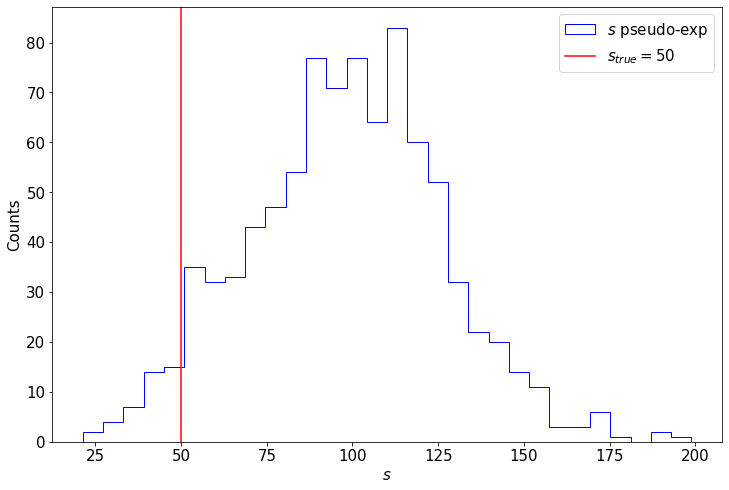

In [24]:
s = 50
dataf, bins,_ = plt.hist(ciao,bins=30,histtype='step',color = 'blue',label=r'$s$ pseudo-exp')
plt.xlabel(r'$s$')
plt.ylabel('Counts')
#plt.grid(True)
plt.axvline(s,color='red',label='$s_{true} = 50$')
plt.legend(loc='best')
plt.savefig("Supi.pdf", bbox_inches='tight')

In [26]:
ndata = 300
s = 5
b = 15
sigmab = 9.5
experiment = generate_data(s, b, sigmab)

limit = chi2(1).ppf(0.90) # 95% 
ok_upper_limit = 0

for i in tqdm( range (ndata) ):

    n = experiment[0][i]
    bbar = experiment[1][i]
    
    res = minimize(partial(nll_2d,model_constraint_2d_freq,n,bbar=bbar,sigmab=sigmab),x0=(s,b),bounds=[(0,np.inf),(0,np.inf),]) # calcolo b capp e s capp
    bestNLL = res.fun
    t = np.array([])
    
    par_s = np.linspace(1,50, 400) #deve essere intorno al 50...nel primo caso.
    
    print('sbest = %.2f'%(res.x[0]))
    for si in par_s:
        res = minimize(partial(nll,model_constraint_freq,n,si,bbar=bbar,sigmab=sigmab),x0=(b,),bounds=[(0,np.inf),])
        t = np.append(t,testStatistic(model=model_constraint_freq,n=n,s=si,b=res.x[0],bestNLL=bestNLL,bbar=bbar,sigmab=sigmab))
        
    idx = (t>limit).argmax()
    if(idx != 0):
        upper_limit = 0.5*(par_s[idx]+par_s[idx-1])
    else:
        upper_limit = par_s[idx]
    print('sigmab = %.2f, n = %.2f, bbar = %.2f, limit = %.2f, upper limit on s = %.2f'%(sigmab, n, bbar, limit, upper_limit))

    file = open("Uno.txt", "a")
    file.write(str(upper_limit) + "\n")
    file.close()

    if(upper_limit >= s):
        ok_upper_limit = ok_upper_limit + 1

  0%|          | 0/300 [00:00<?, ?it/s]

sbest = 7.68


  0%|          | 1/300 [00:12<1:04:26, 12.93s/it]

sigmab = 9.50, n = 18.00, bbar = 10.32, limit = 2.71, upper limit on s = 23.78
sbest = 0.00


  1%|          | 2/300 [00:26<1:06:56, 13.48s/it]

sigmab = 9.50, n = 19.00, bbar = 32.51, limit = 2.71, upper limit on s = 8.55
sbest = 22.25


  1%|          | 2/300 [00:39<1:38:19, 19.80s/it]


KeyboardInterrupt: 

In [48]:
s = 5
sup_2 = np.array([])
f_2 = open("Es_due.txt", "r")
for line in f_2.readlines():
    sup_2 = np.append(sup_2, float(line))
f_2.close()

coverage_2 = len(sup_2[sup_2>s])/len(sup_2)
coverage_2

0.9847715736040609

In [49]:
ciao_2 = sup_2[sup_2>= 1]
coverage_2 = len(ciao_2[ciao_2>s])/len(ciao_2)
coverage_2

0.9847715736040609

In [50]:
len(ciao_2)

985

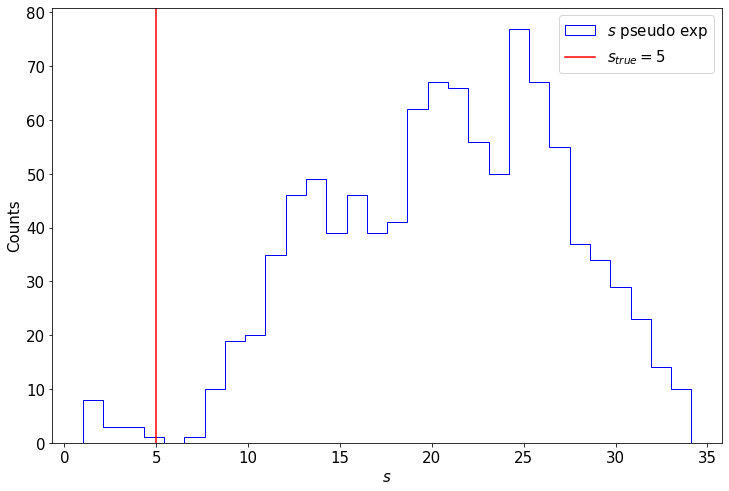

In [46]:
dataf, bins,_ = plt.hist(ciao_2,bins=30,histtype='step',color = 'blue',label=r'$s$ pseudo exp')
plt.xlabel(r'$s$')
plt.ylabel('Counts')
plt.axvline(s,color='red',label='$s_{true}  = 5$')
plt.legend(loc='best')
plt.savefig("ziozi.pdf", bbox_inches='tight')